In [176]:
#Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.patches as mpatches
#LEFT TO DO : Reorganize PCA analysis (done except for showing PCA components for all countries price features), 
#More inital EDA/statistical analysis (done: check data for outliers/distribution)(add: cleaning for months, 
#cleaning for yeilds (done : Price = 12, yeild = 7, drop other colums as there is not enough... carloads is already uniform dist interestingly), 
#then visualize yeild per month(done) 
#add correlation matrix between : Price = 12($), Price = 7(Yeild),Location(Region),Year(Range) (DONE). To see relationship more. Fix region ID
#adding more data using worldbank&IMF fund. 
#can add clustering test to Price before cleaning , for added machine learning methods (not really necessary)
#add to challenges - length of time it took to calculate optimal mode for LSTM algorithm perhaps find literature on how to optimize.(hyperparamter tuning) 
#switch regions so it is added earlier or remove from correlation matrix 
#add how we modified data uniform not spread evenly to be more spread evenly.
#save best model then do not run cell again. 

In [15]:
#Data imports
feedgrains_df = pd.read_csv(r"C:\Users\AlexChacon\Downloads\FeedGrains\FeedGrains.csv", header=None)

# === Assign Column Names to FeedGrains Dataset ===
feedgrains_df.columns = ["col1", "category", "col3", "commodity", "col5", "col6", 
                         "country", "col8", "col9", "col10", "metric", "col12", 
                         "unit", "year", "col15", "period", "col17", "market_type", 
                         "yield"]


final_combined_df = feedgrains_df

print(f"Number of entries in final combined dataset: {len(final_combined_df)}")
print(final_combined_df.head())

Number of entries in final combined dataset: 524369
          col1        category               col3            commodity  \
0  SC_Group_ID   SC_Group_Desc  SC_GroupCommod_ID  SC_GroupCommod_Desc   
1            2  Supply and use                  9               Barley   
2            2  Supply and use                  9               Barley   
3            2  Supply and use                  9               Barley   
4            2  Supply and use                  9               Barley   

              col5       col6                    country             col8  \
0  SC_Geography_ID  SortOrder  SC_GeographyIndented_Desc  SC_Commodity_ID   
1                1      0.800              United States                1   
2                1      0.800              United States                1   
3                1      0.800              United States                1   
4                1      0.800              United States                1   

                col9            col10   

C:\Users\AlexChacon\AppData\Local\Temp\ipykernel_24812\1469300027.py:2: DtypeWarning: Columns (0,2,4,5,7,9,11,13,14,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  feedgrains_df = pd.read_csv(r"C:\Users\AlexChacon\Downloads\FeedGrains\FeedGrains.csv", header=None)


In [17]:
#Data cleaning
# Rename the columns in the final combined dataset asthey appear on row 2 of the dataset
final_combined_df.columns = ['SC_Group_ID', 'SC_Group_Desc', 'SC_GroupCommod_ID', 'SC_GroupCommod_Desc', 
                            'SC_Geography_ID', 'SortOrder', 'SC_GeographyIndented_Desc', 'SC_Commodity_ID', 
                            'SC_Commodity_Desc', 'SC_Attribute_ID', 'SC_Attribute_Desc', 'SC_Unit_ID', 
                            'SC_Unit_Desc', 'Year_ID', 'SC_Frequency_ID', 'SC_Frequency_Desc', 'Timeperiod_ID', 
                            'Timeperiod_Desc', 'Amount'
                            ]
# Drop the second row of the final combined dataset
final_combined_df.drop(0, inplace=True)
print(final_combined_df.head())

  SC_Group_ID   SC_Group_Desc SC_GroupCommod_ID SC_GroupCommod_Desc  \
1           2  Supply and use                 9              Barley   
2           2  Supply and use                 9              Barley   
3           2  Supply and use                 9              Barley   
4           2  Supply and use                 9              Barley   
5           2  Supply and use                 9              Barley   

  SC_Geography_ID SortOrder SC_GeographyIndented_Desc SC_Commodity_ID  \
1               1     0.800             United States               1   
2               1     0.800             United States               1   
3               1     0.800             United States               1   
4               1     0.800             United States               1   
5               1     0.800             United States               1   

  SC_Commodity_Desc SC_Attribute_ID         SC_Attribute_Desc SC_Unit_ID  \
1            Barley               3  Yield per harvested a

In [19]:
#Data Exploration
print(final_combined_df.describe())

        SC_Group_ID        SC_Group_Desc  SC_GroupCommod_ID  \
count        524368               524368           516928.0   
unique           14                    7               26.0   
top               3  Exports and imports               12.0   
freq         436625               458736           243774.0   

       SC_GroupCommod_Desc  SC_Geography_ID  SortOrder  \
count               516928           524368   524368.0   
unique                  13              301      301.0   
top                   Corn                1        0.8   
freq                254332            35463    35463.0   

       SC_GeographyIndented_Desc  SC_Commodity_ID SC_Commodity_Desc  \
count                     524368           524368            524368   
unique                       272              151                78   
top                United States                2              Corn   
freq                       41914            84001             86539   

        SC_Attribute_ID              

In [21]:
#Data Exploration
print(final_combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524368 entries, 1 to 524368
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   SC_Group_ID                524368 non-null  object
 1   SC_Group_Desc              524368 non-null  object
 2   SC_GroupCommod_ID          516928 non-null  object
 3   SC_GroupCommod_Desc        516928 non-null  object
 4   SC_Geography_ID            524368 non-null  object
 5   SortOrder                  524368 non-null  object
 6   SC_GeographyIndented_Desc  524368 non-null  object
 7   SC_Commodity_ID            524368 non-null  object
 8   SC_Commodity_Desc          524368 non-null  object
 9   SC_Attribute_ID            524368 non-null  object
 10  SC_Attribute_Desc          524368 non-null  object
 11  SC_Unit_ID                 524368 non-null  object
 12  SC_Unit_Desc               524368 non-null  object
 13  Year_ID                    524368 non-null  

In [23]:
#Data Exploration 
print(final_combined_df.isnull().sum())

SC_Group_ID                     0
SC_Group_Desc                   0
SC_GroupCommod_ID            7440
SC_GroupCommod_Desc          7440
SC_Geography_ID                 0
SortOrder                       0
SC_GeographyIndented_Desc       0
SC_Commodity_ID                 0
SC_Commodity_Desc               0
SC_Attribute_ID                 0
SC_Attribute_Desc               0
SC_Unit_ID                      0
SC_Unit_Desc                    0
Year_ID                         0
SC_Frequency_ID                 0
SC_Frequency_Desc               0
Timeperiod_ID                   0
Timeperiod_Desc                 0
Amount                          0
dtype: int64


In [25]:
#Data cleaning
#check the minimum year and maximum year in the final combined dataset
year = final_combined_df['Year_ID'].astype(int)
print(year.min())
print(year.max())
# The intervals are as follows:
#1866 - 1886 as 1
#1887 - 1907 as 2
#1908 - 1928 as 3
#1929 - 1949 as 4
#1950 - 1970 as 5
#1971 - 1991 as 6
#1992 - 2012 as 7
#2013 - 2025 as 8

1866
2025


In [27]:
#Data cleaning 
# Ensure Year_ID is float
final_combined_df['Year_ID'] = final_combined_df['Year_ID'].astype(float)

# Define the intervals
intervals = [
    (1866, 1886),
    (1887, 1907),
    (1908, 1928),
    (1929, 1949),
    (1950, 1970),
    (1971, 1991),
    (1992, 2012),
    (2013, 2025)
]

# Function to assign year range label
def get_year_range(year):
    try:
        year = int(year)
        for idx, (start, end) in enumerate(intervals, start=1):
            if start <= year <= end:
                return idx
    except (ValueError, TypeError):
        return None
    return None

# Create a new column for year range
final_combined_df['Year_Range'] = final_combined_df['Year_ID'].apply(get_year_range)

# Preview result
print(final_combined_df[['Year_ID', 'Year_Range']].head())

   Year_ID  Year_Range
1   2005.0           7
2   2006.0           7
3   2007.0           7
4   2008.0           7
5   2009.0           7


In [29]:
#Data cleaning
#Check the unique values in the 'countrycode' column

# Strip column names to remove any accidental spaces
final_combined_df.columns = final_combined_df.columns.str.strip()

# Now assign to locations
locations = final_combined_df['SC_GeographyIndented_Desc'].unique()

# Check the result
print(locations)


['United States' '  World less U.S.' 'U.S. - Central IL'
 'U.S. - Gulf ports, LA' 'U.S. - Omaha, NE' 'U.S. - Chicago, IL'
 'U.S. - Kansas City, MO' 'U.S. - Toledo, OH' 'U.S. - Memphis, TN'
 'U.S. - Minneapolis, MN' 'World' 'U.S. - Midwest' 'U.S. - AR points'
 'U.S. - IL points, IL' 'U.S. - Central US' 'U.S. - AR'
 'U.S. - Domestic, East Coast' 'U.S. - New York, NY' '  Latin America'
 '      Central America' '      Caribbean' '      South America'
 '        European Union-15' '    Asia and Middle East'
 '      Middle East' '        South Asia' 'U.S. - Lawrenceburg, IN'
 'U.S. - St Louis, MO' '        Southeast Asia' '    Oceania'
 '      North Africa' '    Africa' '      Sub-Saharan Africa'
 '    Western Hemisphere' '      North America' '    Europe/Eurasia'
 '      European Union-25' '        Acceding-10' '      Asia'
 '      Other Europe' '      Former Soviet Union-12' '        East Asia'
 '        Canada' '        Greenland' '        Mexico' '        Guatemala'
 '        El Salvador'

In [31]:
#Data exploration
# Check unique values in the 'SC_Commodity_Desc' column and SC_GroupCommod_Desc column
print(final_combined_df['SC_Commodity_Desc'].unique())
print()
print(final_combined_df['SC_GroupCommod_Desc'].unique())
print(final_combined_df['SC_GroupCommod_ID'].unique())

['Barley' 'Feed grains' 'Coarse grains' 'Hay alfalfa (dry)' 'Corn'
 'Hay other (dry)' 'Hay all (dry)' 'Corn grain' 'Oats' 'All animals'
 'Barley feed' 'Barley malting' 'Broiler-feed' 'Market egg-feed'
 'Steer and heifer-corn' 'Hog-corn' 'Milk-feed' 'Turkey-feed' 'Grain'
 'Line-haul railroads, all products' 'Corn gluten feed and meal'
 'Meal and bone meal tankage' 'Wheat millfeeds' 'Dairy' 'Cattle on feed'
 'Other cattle' 'Fats and oils' 'Poultry' 'Other livestock' 'Sorghum'
 'Corn, No. 2 yellow' 'Sorghum, No. 2 yellow' 'Distillers dried grains'
 'Soybean meal, high protein' 'Corn meal, yellow' 'Brewers grits'
 'Alfalfa meal, dehydrated, 17% protein' 'Corn, No. 2 white' 'Wheat bran'
 'Wheat middlings' 'Cottonseed meal, 41% solvent' 'Barley, No. 2 feed'
 'Oats, No. 2 white heavy' 'Barley, No. 3 malting' 'Corn syrup'
 'Feather meal, high protein' 'Hominy feed' 'Meat and bone meal'
 'Rice bran, f.o.b. mills' 'Fish meal, 60% protein' 'Barley grain'
 'Oats grain' 'Oats products' 'Other barle

In [33]:
#Data cleaning 
# Drop unwanted columns
columns_to_drop = [
    'SC_Group_ID', 'SortOrder', 'SC_Commodity_ID',
     'SC_Commodity_Desc', 'SC_Attribute_ID', 'SC_Attribute_Desc', 'SC_Frequency_ID', 'Timeperiod_ID', 
]

final_combined_df = final_combined_df.drop(columns=columns_to_drop, errors='ignore')

# Rename remaining columns
columns_to_rename = {
    'SC_Group_Desc': 'Commodity_Supply_Measure',
    'SC_GroupCommod_Desc': 'Commodity_Type',
    'SC_GeographyIndented_Desc': 'Location',
    'SC_Unit_Desc': 'Price_Meaurement_Type',
    'SC_Frequency_Desc': 'Price_Measurement_Frequency',
    'Timeperiod_Desc': 'Price_Measurement_Timeperiod',
    'Amount': 'Price', 'Year_ID': 'Year', 'SC_Geography_ID': 'Location_ID', 'SC_GroupCommod_ID': 'Commodity_ID', 'SC_Unit_ID' : 'Price_Measurement_ID'
}

final_combined_df = final_combined_df.rename(columns=columns_to_rename)


final_combined_df.head()

# Convert the 'Price' column to float
final_combined_df['Price'] = pd.to_numeric(final_combined_df['Price'], errors='coerce')

# drop rows where conversion failed (NaN values)
final_combined_df = final_combined_df.dropna(subset=['Price'])
print(final_combined_df)

       Commodity_Supply_Measure Commodity_ID Commodity_Type Location_ID  \
1                Supply and use            9         Barley           1   
2                Supply and use            9         Barley           1   
3                Supply and use            9         Barley           1   
4                Supply and use            9         Barley           1   
5                Supply and use            9         Barley           1   
...                         ...          ...            ...         ...   
524364      Exports and imports           17           Oats         300   
524365      Exports and imports           17           Oats         300   
524366      Exports and imports           17           Oats         300   
524367      Exports and imports           17           Oats         300   
524368      Exports and imports           17           Oats         300   

                         Location Price_Measurement_ID Price_Meaurement_Type  \
1                  

                         Price  Price_Measurement_ID
Price                 1.000000             -0.019284
Price_Measurement_ID -0.019284              1.000000


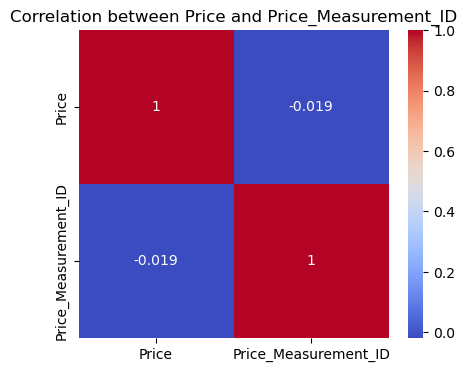

In [35]:
#Data exploration
final_combined_df['Price_Measurement_ID'] = pd.to_numeric(final_combined_df['Price_Measurement_ID'], errors='coerce')

# Drop rows with missing values in either column
final_combined_df = final_combined_df.dropna(subset=['Price', 'Price_Measurement_ID'])

# Compute the correlation matrix
correlation_matrix = final_combined_df[['Price', 'Price_Measurement_ID']].corr()
print(correlation_matrix)

# Optional: visualize it
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Price and Price_Measurement_ID')
plt.show()


📊 Variance of Selected Columns:
Price_Measurement_ID: 9.32
Commodity_ID: 9.64
Location_ID: 6443.73
Year: 167.17
Year_Range: 0.49


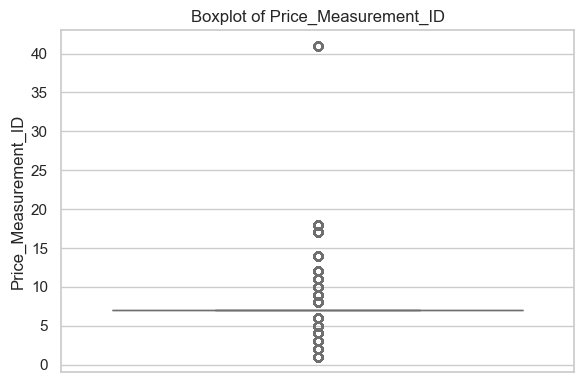

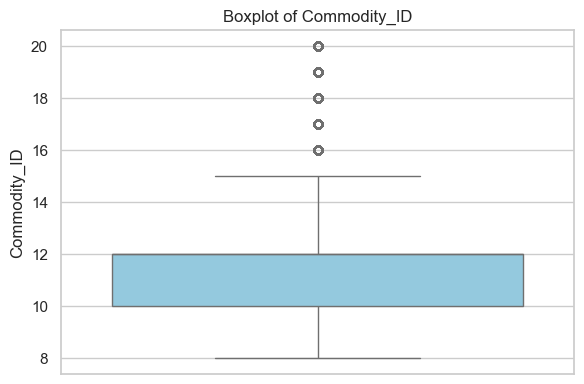

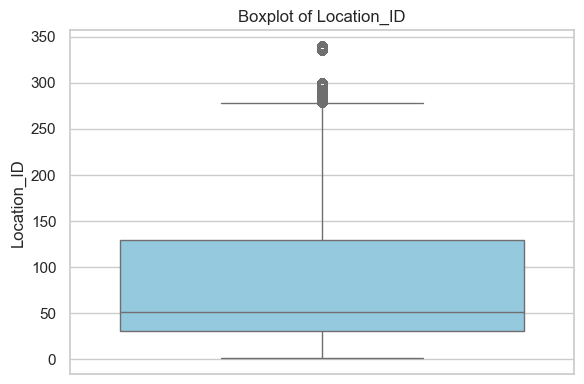

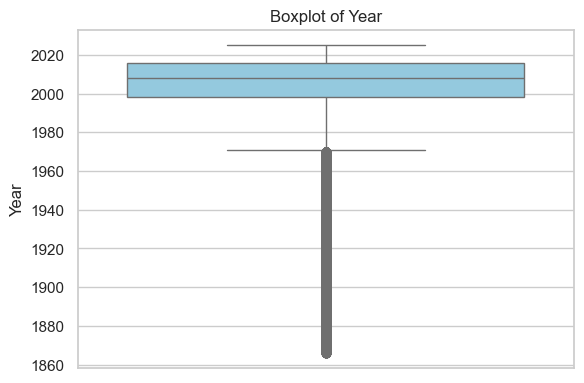

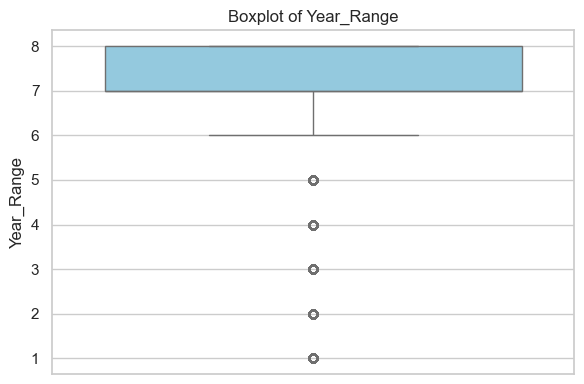

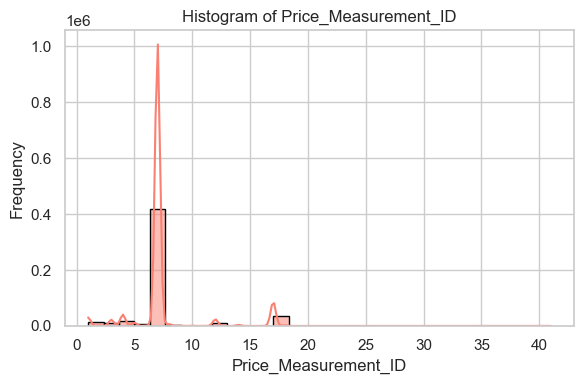

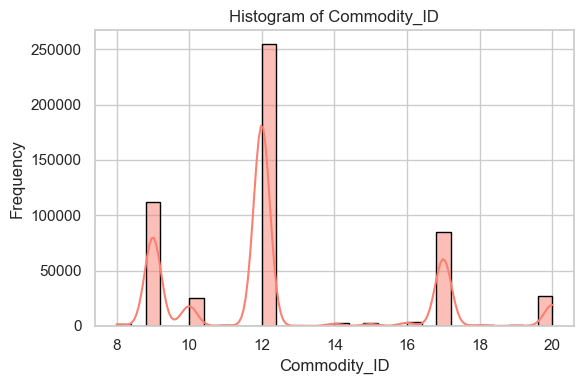

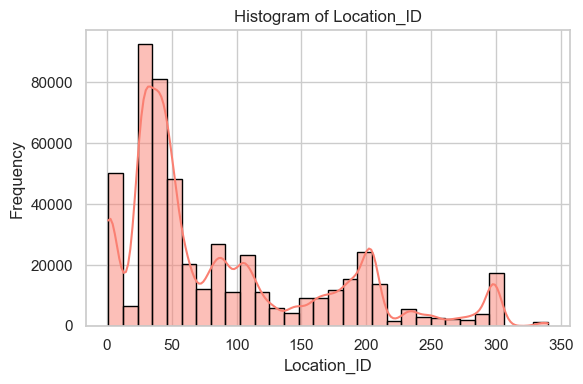

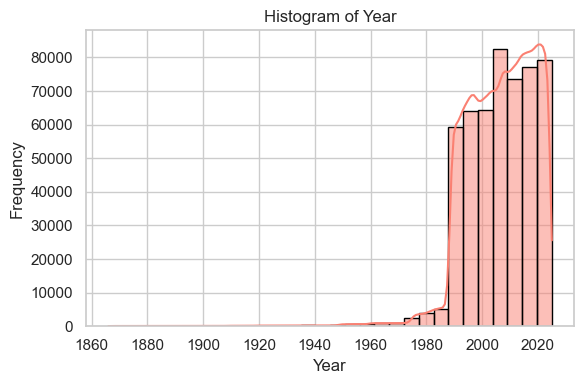

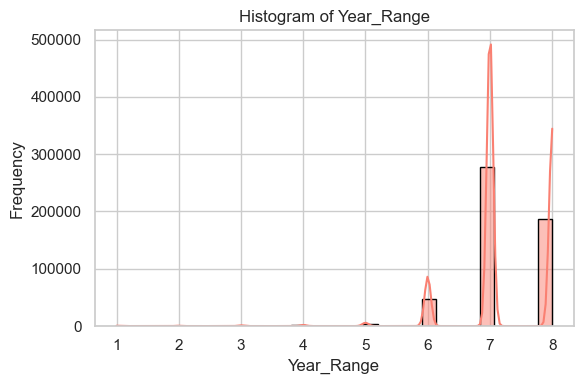

In [37]:
#Data Exploration/Checking data for distribution, variances. 
# Columns of interest
# Columns of interest
columns = ['Price_Measurement_ID', 'Commodity_ID', 'Location_ID', 'Year', 'Year_Range']

# Drop rows with missing values
df_clean = final_combined_df[columns].dropna().copy()

# Convert all columns to numeric (if not already)
for col in columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Re-drop any rows that may have become NaN due to conversion
df_clean = df_clean.dropna()

# Calculate and print variance
print("📊 Variance of Selected Columns:")
for col in columns:
    var = df_clean[col].var()
    print(f"{col}: {var:.2f}")

# Set seaborn style
sns.set(style="whitegrid")

# Plot individual boxplots
for col in columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_clean[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

# Plot individual histograms
for col in columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_clean[col], bins=30, kde=True, color='salmon', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

C:\Users\AlexChacon\AppData\Local\Temp\ipykernel_24812\626846492.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price_Measurement_ID', y='Price', data=avg_price_by_measurement, palette='viridis')


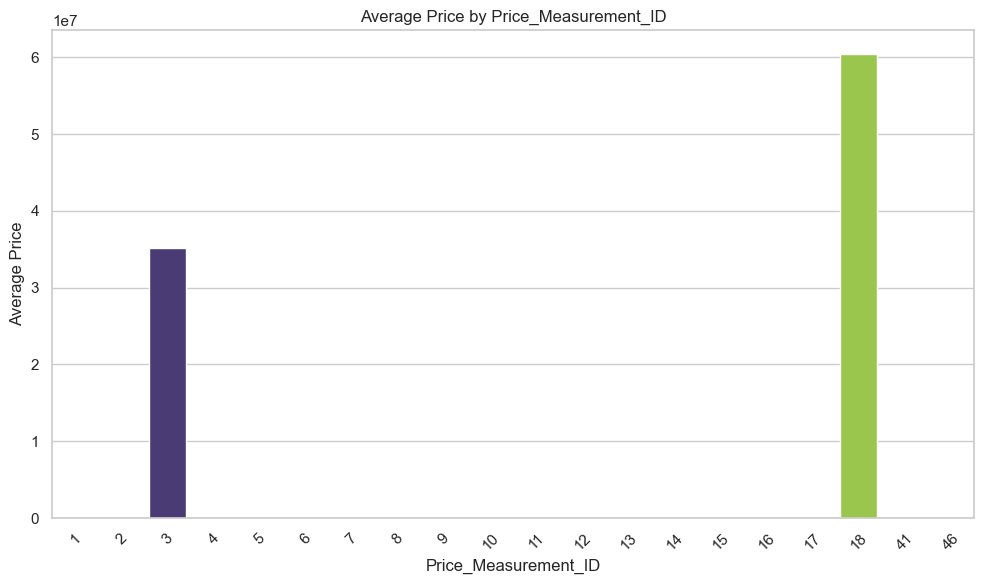

In [38]:
#Data exploration
# Ensure correct types
final_combined_df['Price'] = pd.to_numeric(final_combined_df['Price'], errors='coerce')
final_combined_df['Price_Measurement_ID'] = pd.to_numeric(final_combined_df['Price_Measurement_ID'], errors='coerce')

# Drop rows with missing values in either column
filtered_df = final_combined_df.dropna(subset=['Price', 'Price_Measurement_ID'])

# Calculate average price per Price_Measurement_ID
avg_price_by_measurement = filtered_df.groupby('Price_Measurement_ID')['Price'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Price_Measurement_ID', y='Price', data=avg_price_by_measurement, palette='viridis')
plt.title('Average Price by Price_Measurement_ID')
plt.xlabel('Price_Measurement_ID')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
#Data cleaning 
# Conversion factor from short tons to metric tons
conversion_factor = 0.90718474

# Mask for the rows where the price needs to be converted
mask = final_combined_df['Price_Measurement_ID'] == 12

# Update the Price column for those rows
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] / conversion_factor

unique_commodities = final_combined_df[final_combined_df['Price_Measurement_ID'] == 4]['Commodity_Type'].dropna().unique()
print(unique_commodities)
#SOURCE : https://grains.org/markets-tools-data/tools/converting-grain-units/
#barley = 1 bushel = .021772 metric ton
#corn&sorghum = 1 bushel = .0254 metric ton
#oats = 1 bushel = .0272155 metric ton
# Define conversion factors (bushel → metric ton)
bushel_to_metric_ton = {
    'barley': 0.021772,
    'corn': 0.0254,
    'sorghum': 0.0254,
    'oats': 0.0272155
}

# Create a mask for rows with Price_Measurement_ID == 4
mask = final_combined_df['Price_Measurement_ID'] == 4

# Create a copy to avoid modifying the original DataFrame
#df_final_combined_df = final_combined_df.copy()

# Apply conversion where applicable
for commodity, factor in bushel_to_metric_ton.items():
    commodity_mask = (final_combined_df['Commodity_Type'].str.lower() == commodity) & mask
    final_combined_df.loc[commodity_mask, 'Price'] = final_combined_df.loc[commodity_mask, 'Price'] / factor 
    final_combined_df.loc[commodity_mask, 'Price_Measurement_ID'] = 12  # Change to price per metric ton

# Conversion factor: 1 dollar per cwt = ~22.0462 dollars per metric ton
cwt_to_metric_ton_factor = 2204.62 / 100  # ≈ 22.0462

# Ensure Price is numeric
final_combined_df['Price'] = pd.to_numeric(final_combined_df['Price'], errors='coerce')

# Mask for rows with Price_Measurement_ID == 5 (dollars per cwt)
mask = final_combined_df['Price_Measurement_ID'] == 5

# Apply conversion: dollars per cwt → dollars per metric ton
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * cwt_to_metric_ton_factor

# Update measurement ID to 12 (dollars per metric ton)
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 12

# Conversion factor: 1 cent per pound = 22.0462 dollars per metric ton
cents_to_dollars_per_metric_ton_factor = 2204.62 / 100  # ≈ 22.0462

# Ensure Price is numeric
final_combined_df['Price'] = pd.to_numeric(final_combined_df['Price'], errors='coerce')

# Mask for Price_Measurement_ID == 14 (cents per pound)
mask = final_combined_df['Price_Measurement_ID'] == 14

# Apply conversion in-place for these rows
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * cents_to_dollars_per_metric_ton_factor

# Update Price_Measurement_ID to 12 (for dollars per metric ton)
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 12

# Conversion factor: dollars per metric ton to dollars per 1000 metric tons
dollars_per_metric_ton_to_1000_metric_tons_factor = 1000

# Ensure Price is numeric
final_combined_df['Price'] = pd.to_numeric(final_combined_df['Price'], errors='coerce')

# Mask for Price_Measurement_ID == 12 (dollars per metric ton)
mask = final_combined_df['Price_Measurement_ID'] == 12

# Apply conversion in-place for these rows
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * dollars_per_metric_ton_to_1000_metric_tons_factor

#metric ton = xdensity/1000. 
final_combined_df['Commodity_Type'] = final_combined_df['Commodity_Type'].astype(str).str.strip()

# Filter and get unique Commodity_Type values where Price_Measurement_ID is 17
unique_commodities_id_7 = final_combined_df[final_combined_df['Price_Measurement_ID'] == 17]['Commodity_Type'].dropna().unique()

# Print the result
print("Unique Commodity_Type values for Price_Measurement_ID = 17:")
print(unique_commodities_id_7)

# Define conversion factor: 1000 liters = 0.721 metric tons → convert to price per 1000 metric tons
conversion_factor = 1000 / 0.721

# Apply conversion only to rows where Price_Measurement_ID == 17
mask = final_combined_df['Price_Measurement_ID'] == 17

# Convert Price and update Measurement ID
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * conversion_factor
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 7


# Conversion factor: from per 1 million → per 1
conversion_factor = 1000000

# Mask for Price_Measurement_ID == 1
mask = final_combined_df['Price_Measurement_ID'] == 1

# Apply the conversion
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * conversion_factor 

# Update the measurement ID to 3 (per bushel)
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 3

# Conversion factor: from million metric tons → 1000 metric tons
conversion_factor = 1000

# Mask for Price_Measurement_ID == 8
mask = final_combined_df['Price_Measurement_ID'] == 8

# Apply the conversion and update measurement ID
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * conversion_factor
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 7

# Conversion factor: from million acres → 1000 acres
conversion_factor = 1000

# Mask for Price_Measurement_ID == 2
mask = final_combined_df['Price_Measurement_ID'] == 2

# Apply conversion and update measurement ID
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * conversion_factor
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 10

# Conversion factor: gallons → 1000 metric tons
conversion_factor = 268.47 * 1000  # 1000 metric tons worth of gallons

# Mask for rows with Price_Measurement_ID == 18
mask = final_combined_df['Price_Measurement_ID'] == 18

# Apply conversion and update measurement ID
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] * conversion_factor
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 7

# Conversion factor: US ton → 1000 metric ton
us_to_metric = 0.90718474 / 1000

# Mask for rows with Price_Measurement_ID == 9
mask = final_combined_df['Price_Measurement_ID'] == 9

# Convert to metric tons
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] / us_to_metric

# Update measurement ID to 7 (1000 metric tons)
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 7

# Conversion factor from US ton to 1000 metric ton
us_to_metric = 0.90718474 / 1000

# Mask for rows with Price_Measurement_ID == 41
mask = final_combined_df['Price_Measurement_ID'] == 41

# Convert the Price from US tons to metric tons
final_combined_df.loc[mask, 'Price'] = final_combined_df.loc[mask, 'Price'] / us_to_metric

# Update the Price_Measurement_ID to 7
final_combined_df.loc[mask, 'Price_Measurement_ID'] = 7

# Normalize Commodity_Type formatting
final_combined_df['Commodity_Type'] = final_combined_df['Commodity_Type'].astype(str).str.strip().str.lower()

# Define conversion factors from bushels to 1000 metric tons
bushel_to_metric_ton = {
    'barley': 0.021772 /1000,
    'corn': 0.0254 / 1000,
    'sorghum': 0.0254 / 1000,
    'oats': 0.0272155 / 1000, 
    'Barley': 0.021772 / 1000,
    'Corn': 0.0254 / 1000,
    'Sorghum': 0.0254/ 1000,
    'Oats': 0.0272155 /1000
}

# Mask for rows with Price_Measurement_ID == 3
mask = final_combined_df['Price_Measurement_ID'] == 3

# Loop through each commodity and apply conversion
for commodity, factor in bushel_to_metric_ton.items():
    commodity_mask = (final_combined_df['Commodity_Type'] == commodity) & mask
    final_combined_df.loc[commodity_mask, 'Price'] = final_combined_df.loc[commodity_mask, 'Price'] / factor
    final_combined_df.loc[commodity_mask, 'Price_Measurement_ID'] = 7 # Update measurement ID

# Get unique type-to-ID mapping
unique_price_types = final_combined_df[['Price_Meaurement_Type', 'Price_Measurement_ID']].drop_duplicates()

# Get counts of each Price_Measurement_ID from final_combined_df
price_measurement_counts = final_combined_df['Price_Measurement_ID'].value_counts().reset_index()
price_measurement_counts.columns = ['Price_Measurement_ID', 'Count']

# Merge counts with type-ID mapping
combined_info = pd.merge(unique_price_types, price_measurement_counts, on='Price_Measurement_ID', how='left')

# Display the result
print(combined_info.sort_values(by='Count', ascending=False))
#1,000 metric tons=7, Dollars per 1000 metric ton = 12. Ratio = 13, Million animal units = 46, 1000 acres = 10, bushels per acre = 6, tons per acre = 11


['Barley' 'Corn' 'Oats' 'Sorghum']
Unique Commodity_Type values for Price_Measurement_ID = 17:
['Corn']
   Price_Meaurement_Type  Price_Measurement_ID   Count
19                   Ton                     7  481891
7             1,000 tons                     7  481891
14               Bushels                     7  481891
17          1,000 liters                     7  481891
16               Gallons                     7  481891
4        Million bushels                     7  481891
3      1,000 metric tons                     7  481891
2    Million metric tons                     7  481891
6        Dollars per ton                    12   32968
1     Dollars per bushel                    12   32968
12       Dollars per cwt                    12   32968
15       Cents per pound                    12   32968
9                  Ratio                    13    4927
8   Million animal units                    46    1400
5            1,000 acres                    10    1284
13         Milli

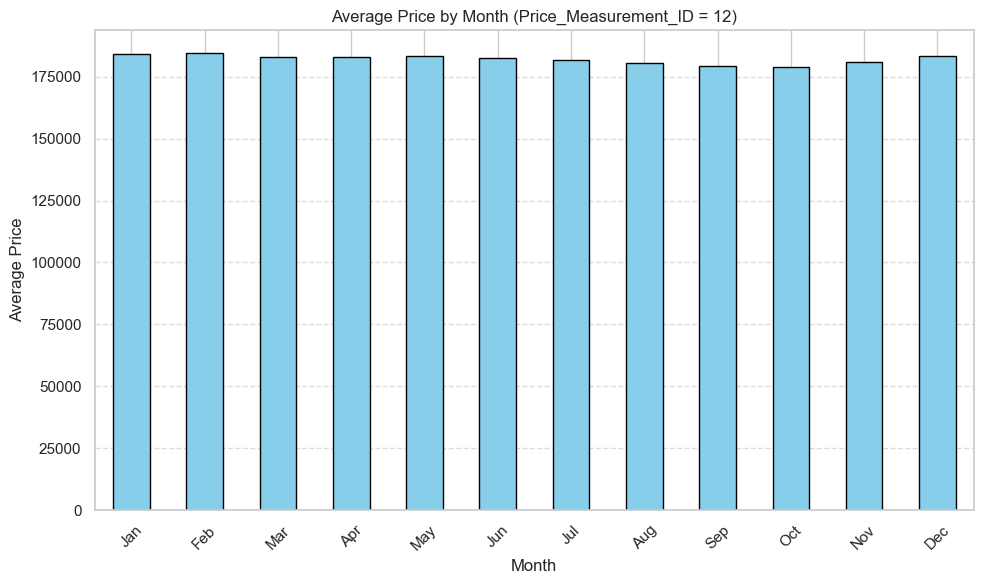

In [40]:
#Data Cleaning - Checking months + EDA visualizing Price Trends per month. 
# Step 1: Define valid months
valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

filtered_months = final_combined_df[
    final_combined_df['Price_Measurement_Timeperiod'].isin(valid_months)
]

# Further filter for Price_Measurement_ID == 7 and positive Price
df_price7 = filtered_months[
    (filtered_months['Price_Measurement_ID'] == 7) & 
    (filtered_months['Price'] > 0)
]

# Step 3: Further filter for Price_Measurement_ID == 12
filtered_months = filtered_months[filtered_months['Price_Measurement_ID'] == 12]

# Step 4: Drop missing or invalid prices
filtered_months = filtered_months[filtered_months['Price'] > 0]

# Step 5: Group by month and compute average price
month_price_avg = filtered_months.groupby('Price_Measurement_Timeperiod')['Price'].mean()

# Optional: Sort by calendar month order
month_price_avg = month_price_avg.reindex(valid_months)

# Step 6: Plot
plt.figure(figsize=(10, 6))
month_price_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Price by Month (Price_Measurement_ID = 12)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

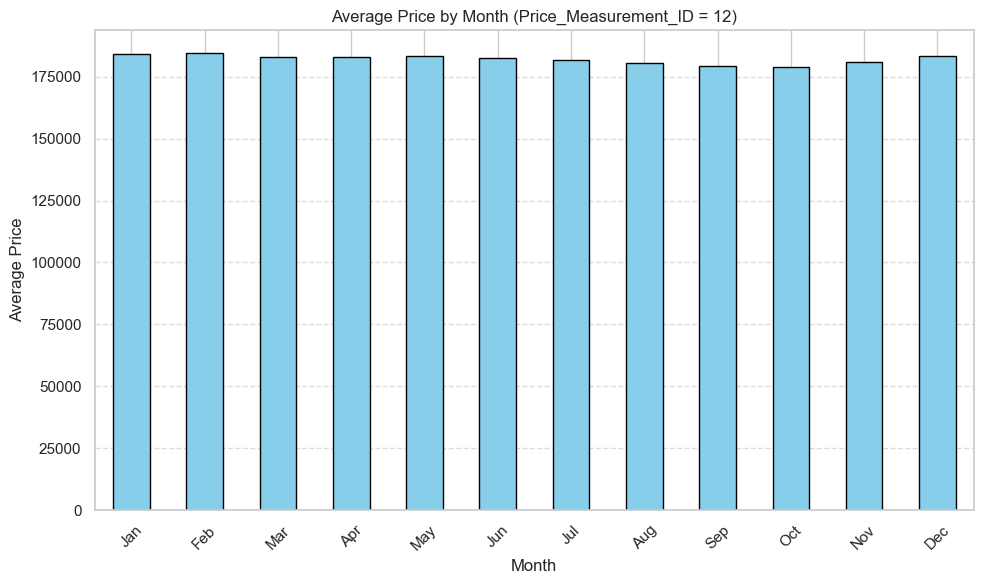

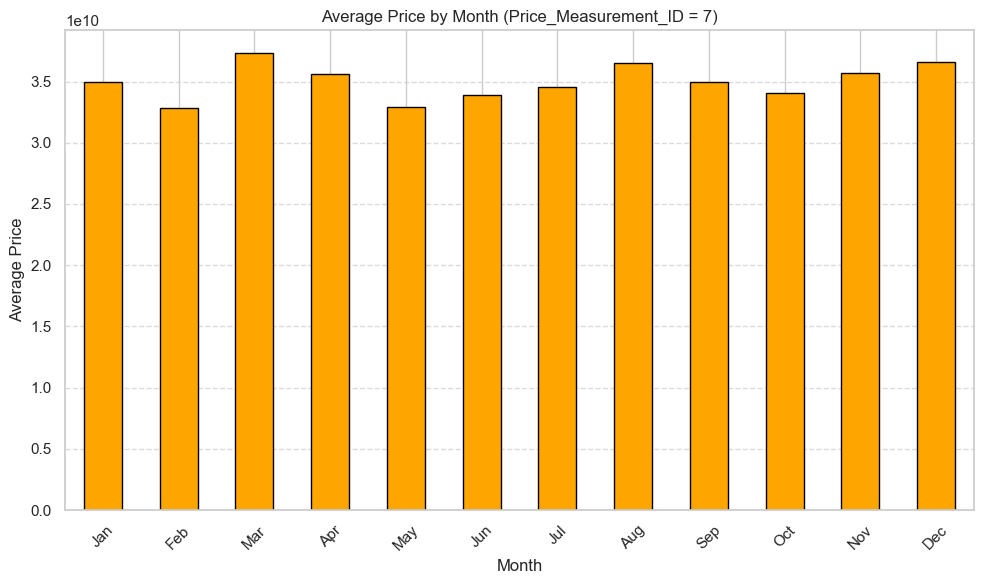

In [41]:
#Data Exploration - showing trends in months in relation to yields. 
# Step 3b: Filter where Price_Measurement_ID == 7 and valid Price
# Data Cleaning - Checking months + EDA visualizing Price Trends per month

# Step 1: Define valid months
valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Step 2: Filter for valid months
filtered_months = final_combined_df[
    final_combined_df['Price_Measurement_Timeperiod'].isin(valid_months)
]

# Step 3: Filter for Price_Measurement_ID == 12 and positive prices
df_price12 = filtered_months[
    (filtered_months['Price_Measurement_ID'] == 12) &
    (filtered_months['Price'] > 0)
]

# Step 4: Group by month and compute average price for ID 12
month_price_avg_12 = df_price12.groupby('Price_Measurement_Timeperiod')['Price'].mean()
month_price_avg_12 = month_price_avg_12.reindex(valid_months)

# Step 5: Plot for Price_Measurement_ID == 12
plt.figure(figsize=(10, 6))
month_price_avg_12.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Price by Month (Price_Measurement_ID = 12)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: Filter for Price_Measurement_ID == 7 and positive prices
df_price7 = filtered_months[
    (filtered_months['Price_Measurement_ID'] == 7) &
    (filtered_months['Price'] > 0)
]

# Step 7: Group by month and compute average price for ID 7
month_price_avg_7 = df_price7.groupby('Price_Measurement_Timeperiod')['Price'].mean()
month_price_avg_7 = month_price_avg_7.reindex(valid_months)

# Step 8: Plot for Price_Measurement_ID == 7
plt.figure(figsize=(10, 6))
month_price_avg_7.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Average Price by Month (Price_Measurement_ID = 7)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
#More Yeild variability by month than Prices...
#Count of rows with Price_Measurement_ID = 7 and valid month time period: 401700

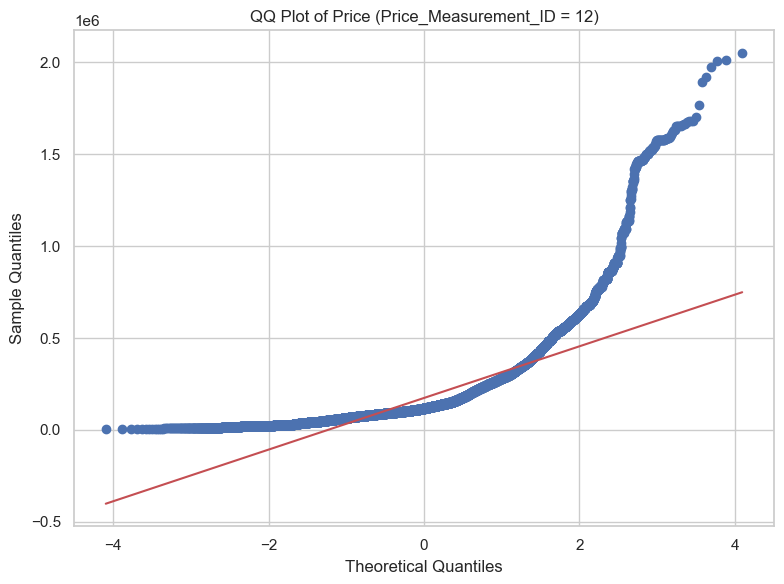

In [42]:
#Data exploration
#most closely follow: 4, 13, 5, 8, 14, 46 , 2, 15, 6, 9, 16, 10, 11,  41
# Filter for rows with Price_Measurement_ID == 7
price_data = final_combined_df[final_combined_df['Price_Measurement_ID'] == 12]['Price'].dropna()

# Create QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(price_data, dist="norm", plot=plt)
plt.title("QQ Plot of Price (Price_Measurement_ID = 12)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
#Data cleaning
# First, fill any NaNs with a placeholder (e.g., 0), then convert to integer
final_combined_df['Location_ID'] = final_combined_df['Location_ID'].fillna(0).astype(int)
final_combined_df['Commodity_ID'] = final_combined_df['Commodity_ID'].fillna(0).astype(int)
final_combined_df = final_combined_df.dropna(subset=['Commodity_Type'])
final_combined_df['Location_ID'] = final_combined_df['Location_ID'].astype(int)
final_combined_df['Commodity_ID'] = final_combined_df['Commodity_ID'].astype(float)
final_combined_df['Location_ID'] = final_combined_df['Location_ID'].astype(float)

In [51]:
#Data exploration
print(final_combined_df['Location_ID'].unique())

[  1.   2.   3.   4.   6.   7.   8.   9.  10.  11.  25.  14.  15.  18.
  20.  21.  16.  23.  26.  27.  28.  29.  30.  31.  32.  33.  17.   5.
  34.  35.  37.  36.  38.  39.  40.  41.  42.  43.  46.  44.  45.  47.
  49.  48.  51.  52.  54.  55.  53.  58.  56.  57.  62.  59.  60.  63.
  64.  65.  66.  67.  68.  61.  69.  77.  70.  71.  72.  73.  74.  75.
  76.  83.  84.  78.  85.  87.  79.  86.  88.  82.  81.  89.  90.  91.
  96.  97. 100.  92. 101.  93.  94. 103. 104. 106. 108. 105. 113. 114.
 118. 120. 121. 122. 124. 125. 126. 127. 128. 129. 116. 131. 132. 141.
 142. 151. 148. 152. 153. 154. 144. 155. 156. 157. 158. 159. 150. 169.
 160. 161. 170. 172. 162. 173. 174. 163. 175. 177. 179. 180. 178. 164.
 166. 181. 187. 182. 183. 184. 185. 186. 189. 190. 191. 192. 195. 199.
 202. 203. 204. 200. 201. 205. 206. 207. 212. 213. 196. 197. 194. 188.
 130. 143. 149. 115. 168. 133. 134. 135. 119. 109. 112. 102.  99. 243.
 244. 245.  80. 117. 136. 137. 138. 140. 147. 208. 209. 210. 246. 247.
 248. 

In [53]:
#Data cleaning
# African countries (No overlaps with other regions)
african_countries = [
    'Mali', 'Guinea', 'Sierra Leone', 'Ivory Coast', 'Ghana', 'The Gambia', 'Niger',
    'Togo', 'Nigeria', 'Gabon', 'Chad', 'St Helena', 'Burkina Faso', 'Benin', 'Guinea-Bissau',
    'Cape Verde Islands', 'Morocco', 'Congo(Kinshasa)', 'Angola', 'Congo(Brazzville)', 'Liberia',
    'Burundi', 'Rwanda', 'Somalia', 'Ethiopia', 'Djibouti', 'Uganda', 'Kenya', 'Seychelles',
    'Tanzania', 'Mauritius', 'Mozambique', 'Madagascar (Malagasy)', 'Algeria', 'Republic Of South Africa',
    'Mayotte', 'Comoros', 'Reunion (Island, French)', 'Namibia', 'Botswana', 'Zambia', 'Swaziland',
    'Zimbabwe', 'Malawi', 'Lesotho', 'Tunisia', 'Egypt', 'Libya', 'Sudan', 'Western Sahara',
    'Equatorial Guinea', 'Mauritania', 'Cameroon', 'Senegal', 'South Sudan', 'Central African Republic', 'North Africa', 'Africa',
    'Eritrea', 'Sub-Saharan Africa', 'Ethiopia, United Ends 6/1993 & New Begin', 'Malagasy'
]

# North American countries (No overlaps with other regions)
north_american_countries = [
    'United States', 'Canada', 'Greenland', 'Mexico',  'U.S. - Central IL', 'U.S. - Gulf ports, LA', 'U.S. - Omaha, NE', 'U.S. - Chicago, IL',
'U.S. - Kansas City, MO', 'U.S. - Toledo, OH', 'U.S. - Memphis, TN', 'U.S. - Minneapolis, MN', 'U.S. - Midwest', 'U.S. - AR points', 'U.S. - IL points, IL', 'U.S. - Central US', 'U.S. - AR',
'U.S. - Domestic, East Coast', 'U.S. - New York, NY', 'U.S. - Lawrenceburg, IN', 'U.S. - St Louis, MO', 'North America', 'Golden Triangle, MT'
]

# South American countries (No overlaps with other regions)
south_american_countries = [
    'Venezuela', 'Guyana', 'Suriname', 'Ecuador', 'French Guiana', 'Peru', 'Colombia', 'Bolivia', 'Chile',
    'Brazil', 'Paraguay', 'Uruguay', 'Argentina', 'Latin America', 'Central America'
]

# Caribbean countries (No overlaps with other regions)
caribbean_countries = [
    'Jamaica', 'Bermuda', 'Bahamas', 'Turks And Caicos Islands', 'Cayman Islands', 'Haiti', 'Dominican Republic',
    'Anguilla', 'British Virgin Islands', 'Cuba', 'St. Kitts-Nevis', 'Trinidad And Tobago', 'Antigua & Barbuda',
    'Montserrat', 'Dominica', 'St. Lucia', 'St. Vincent And The Grenadine', 'Grenada', 'Barbados',
    'Netherlands Antilles', 'Martinique', 'Guadeloupe', 'Aruba', 'Curacao', 'Sint Maarten', 'Caribbean', 'Caribbean Basin (CBERA)'
]

# Middle Eastern countries (No overlaps with other regions)
middle_eastern_countries = [
    'Jordan', 'Syria', 'Kuwait', 'Saudi Arabia', 'Lebanon', 'Qatar', 'United Arab Emirates', 'Iraq',
    'Yemen', 'Oman', 'Iran', 'Israel', 'Bahrain', 'West Bank', 'Palestine', 'Yemen (Sana), Ends 9/1990 & United Begin', '      Middle East', '        Turkey'
]

# European countries (No overlaps with other regions)
european_countries = [
    'Iceland', 'Sweden', 'Norway', 'Finland', 'Denmark', 'United Kingdom', 'Netherlands', 'Belgium', 'Ireland',
    'France', 'Germany', 'Czech Republic', 'Hungary', 'Liechtenstein', 'Switzerland', 'Estonia', 'Latvia',
    'Lithuania', 'Poland', 'Austria', 'Ukraine', 'Armenia', 'Spain', 'Portugal', 'Slovenia', 'Italy',
    'Bosnia-Hercegovina', 'Macedonia (Skopje)', 'Serbia', 'Montenegro', 'Malta And Gozo', 'Albania', 'Greece',
    'Romania', 'Bulgaria', 'Croatia', 'Cyprus', 'Slovakia', 'Kosovo', 'Belarus', 'Moldova', 'Georgia',
    'Azerbaijan', 'Luxembourg', 'Monaco', 'Svalbard And Jan Mayen Island', 'Faroe Islands', 'Europe/Eurasia', 'European Union-25', 
    'Other Europe', 'Former Soviet Union-12', 'European Union-27', 'Former Yugoslavia, Ends 5/1992',
    'German Democratic Republic, Ends 9/1990', 'Former Czechoslovakia, Ends 12/1992',
    'Former Ussr, Begins 1/1989 & Ends 1/1993', 'Russian Federation, Begins 2/1992', 'Malta And Gozo','          Gibraltar','          Vatican City'
]

# Oceania countries (No overlaps with other regions)
oceania_countries = [
    'Australia', 'Papua New Guinea', 'New Zealand', 'Norfolk Island', 'Cocos (Keeling) Islands',
    'Christmas Island', 'Samoa', 'French Polynesia', 'Fiji', 'Tonga', 'Micronesia', 'Marshall Islands',
    'Palau', 'Kiribati', 'New Caledonia', 'Solomon Islands', 'Cook Islands', 'Sao Tome And Principe',
    'Tokelau Islands', 'Niue', 'Oceania', 'New Zealand, No Islands (=Old Code 6140)', 'Australia (No Islands)', 'Micronesia, Federated States'
]

# Asian countries (No overlaps with other regions)
asian_countries = [
    'Afghanistan', 'India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan', 'Maldives', 'Myanmar (Burma)',
    'Thailand', 'Vietnam', 'Cambodia', 'Laos', 'Malaysia', 'Singapore', 'Indonesia', 'Philippines', 'Brunei',
    'China', 'Mongolia', 'Taiwan', 'South Korea', 'North Korea', 'Japan', 'Hong Kong', 'Macao', 'Southeast Asia', 'Asia', 'East Asia', 'Macao (Macau)',
     '          Kazakhstan', '          Kyrgyzstan', '          Tajikistan',
     '          Uzbekistan','          Turkmenistan'
]
north_american_countries += ['U.S. - Lawrenceburg, IN', 'U.S. - St Louis, MO', 'Golden Triangle, MT']

# Additional South American countries or regions
south_american_countries += ['Latin America', 'Central America', '      South America','        Guatemala', '        El Salvador',
 '        Honduras', '        Belize','        Panama','        Nicaragua',
 '        Costa Rica']

# Additional European regions
european_countries += ['European Union-15', 'European Union-25', 'European Union-27', 'Europe/Eurasia']

# Additional African countries or regions
african_countries += ['Sub-Saharan Africa', 'Africa', 'North Africa']

# Additional Asian countries or regions
asian_countries += ['Asia and Middle East', 'East Asia', 'Southeast Asia']


# Helper function to escape the countries list
def escape_countries(country_list):
    return '|'.join([re.escape(country) for country in country_list])


# Define a list of tuples with region ID and corresponding country list
region_mapping = [
    (1, african_countries),
    (2, north_american_countries),
    (3, south_american_countries),
    (4, caribbean_countries),
    (5, middle_eastern_countries),
    (6, european_countries),
    (7, oceania_countries),
    (8, asian_countries),
]

# Initialize the new Region_ID column with NaNs (float-compatible)
final_combined_df['Region_ID'] = np.nan

# Assign Region_ID based on country matches
for region_id, country_list in region_mapping:
    final_combined_df.loc[
        final_combined_df['Location'].str.contains(escape_countries(country_list), case=False, na=False),
        'Region_ID'
    ] = float(region_id)

# Ensure the column is of float type
final_combined_df['Region_ID'] = final_combined_df['Region_ID'].astype(float)

# List of locations to drop
locations_to_drop = [
    'World', 'World less U.S.', 'Unidentified Country', 'Western Hemisphere', 
    '    Western Hemisphere', '        Acceding-10', '    Unidentified Country'
]

# Drop rows with undesired locations
final_combined_df = final_combined_df[~final_combined_df['Location'].isin(locations_to_drop)]
print(final_combined_df.isnull().sum())

Commodity_Supply_Measure           0
Commodity_ID                       0
Commodity_Type                     0
Location_ID                        0
Location                           0
Price_Measurement_ID               0
Price_Meaurement_Type              0
Year                               0
Price_Measurement_Frequency        0
Price_Measurement_Timeperiod       0
Price                              0
Year_Range                         0
Region_ID                       2600
dtype: int64


In [55]:
#Data cleaning 
final_combined_df = final_combined_df.dropna()
final_combined_df['Year'] = final_combined_df['Year'].astype(float)
final_combined_df['Location_ID'] = final_combined_df['Location_ID'].astype(float)
final_combined_df['Price'] = final_combined_df['Price'].astype(float)

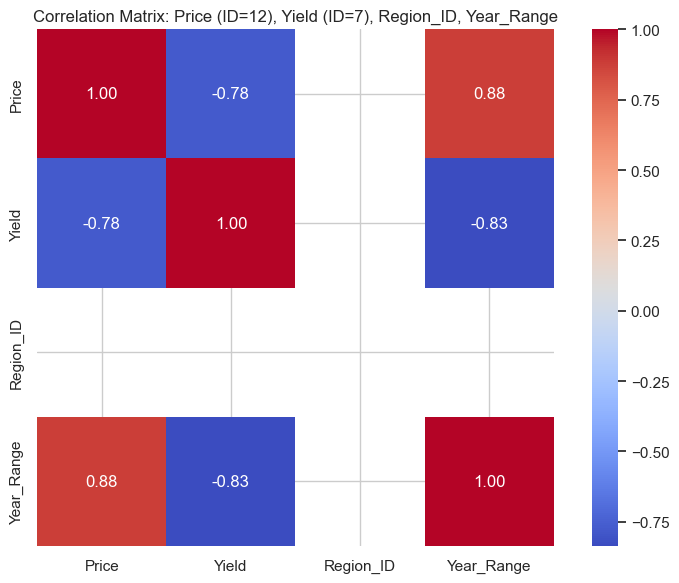

In [57]:
#Data Exploration 
# Step 1: Filter and rename
price_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 12) & (final_combined_df['Price'] > 0)
][['Region_ID', 'Year_Range', 'Price']]

yield_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 7) & (final_combined_df['Price'] > 0)
][['Region_ID', 'Year_Range', 'Price']].rename(columns={'Price': 'Yield'})

# Step 2: Aggregate to avoid Cartesian explosion
price_df = price_df.groupby(['Region_ID', 'Year_Range'])['Price'].mean().reset_index()
yield_df = yield_df.groupby(['Region_ID', 'Year_Range'])['Yield'].mean().reset_index()

# Step 3: Merge safely
merged_df = pd.merge(price_df, yield_df, on=['Region_ID', 'Year_Range'], how='inner')

# Step 4: Correlation
correlation_matrix = merged_df[['Price', 'Yield', 'Region_ID', 'Year_Range']].corr()

# Step 5: Plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix: Price (ID=12), Yield (ID=7), Region_ID, Year_Range")
plt.tight_layout()
plt.show()

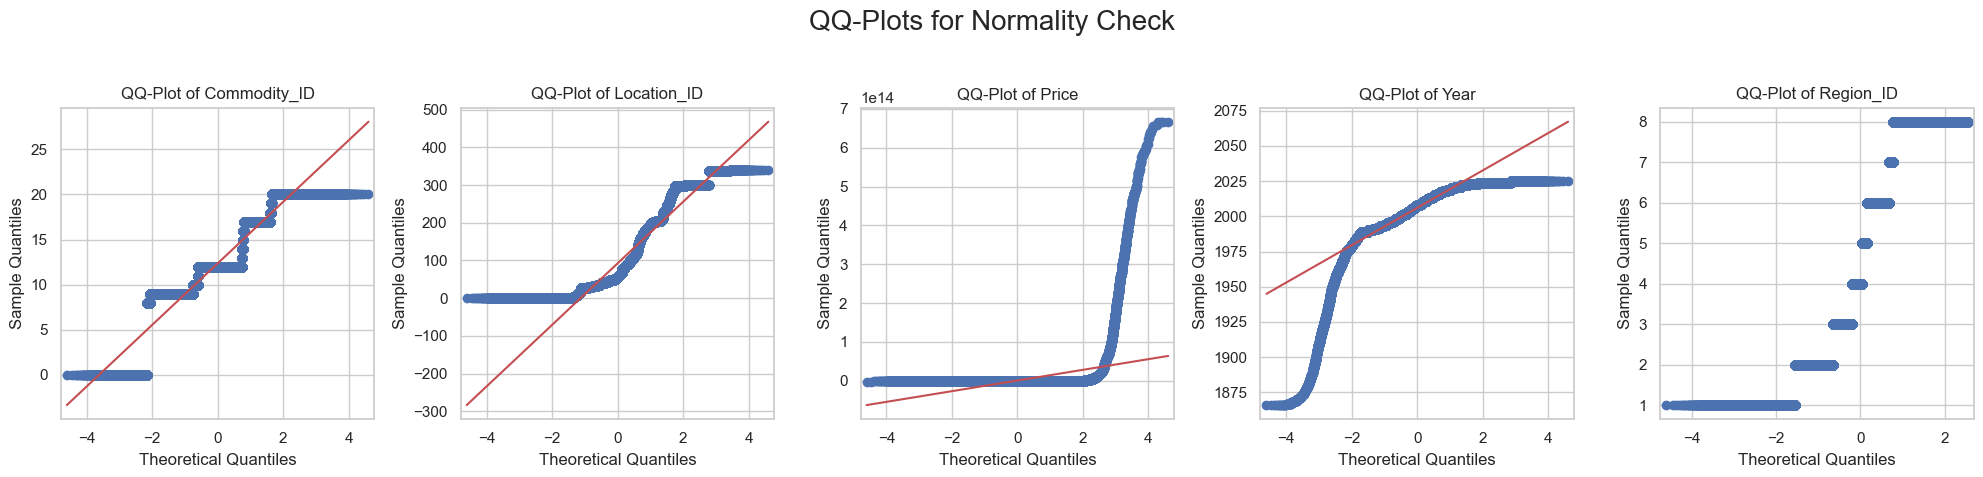

In [59]:
#Data exploration
# Apply QQ-plot for normality check
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create a figure with subplots for each variable
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('QQ-Plots for Normality Check', fontsize=20)
variables = ['Commodity_ID', 'Location_ID', 'Price', 'Year', 'Region_ID']
for i, var in enumerate(variables):
    sm.qqplot(final_combined_df[var], line='s', ax=axes[i])
    axes[i].set_title(f'QQ-Plot of {var}')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')
    axes[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [60]:
#Data cleaning
final_combined_df = final_combined_df[final_combined_df['Year'] >= 1955].copy()

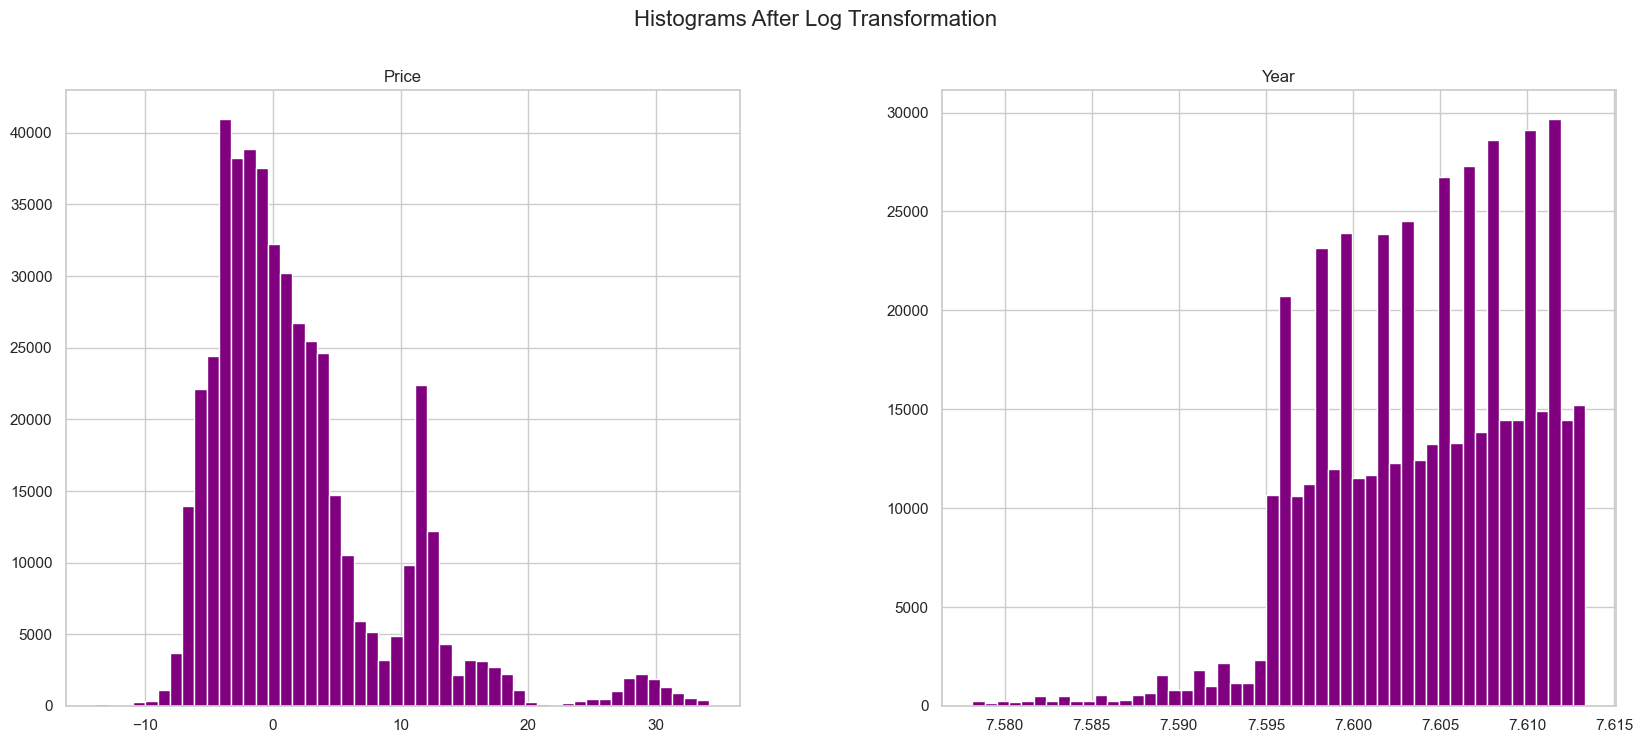

In [63]:
#Data cleaning 
#May need to fix to account for only price variables being located in Price_measurment_id = 7
# Make a copy to preserve the original DataFrame
log_df = final_combined_df.copy()

# Replace non-positive values with NaN to avoid log issues (Price and Year)
log_df['Price'] = log_df['Price'].apply(lambda x: np.nan if x <= 0 else x)
log_df['Year'] = log_df['Year'].apply(lambda x: np.nan if x <= 0 else x)

# Apply log transformation
log_df['Price'] = np.log(log_df['Price'])
log_df['Year'] = np.log(log_df['Year'])

# Plot histograms for log-transformed numeric columns
log_df[['Price', 'Year']].hist(bins=50, figsize=(20, 8), color='purple')
plt.suptitle("Histograms After Log Transformation", fontsize=16)
plt.show()

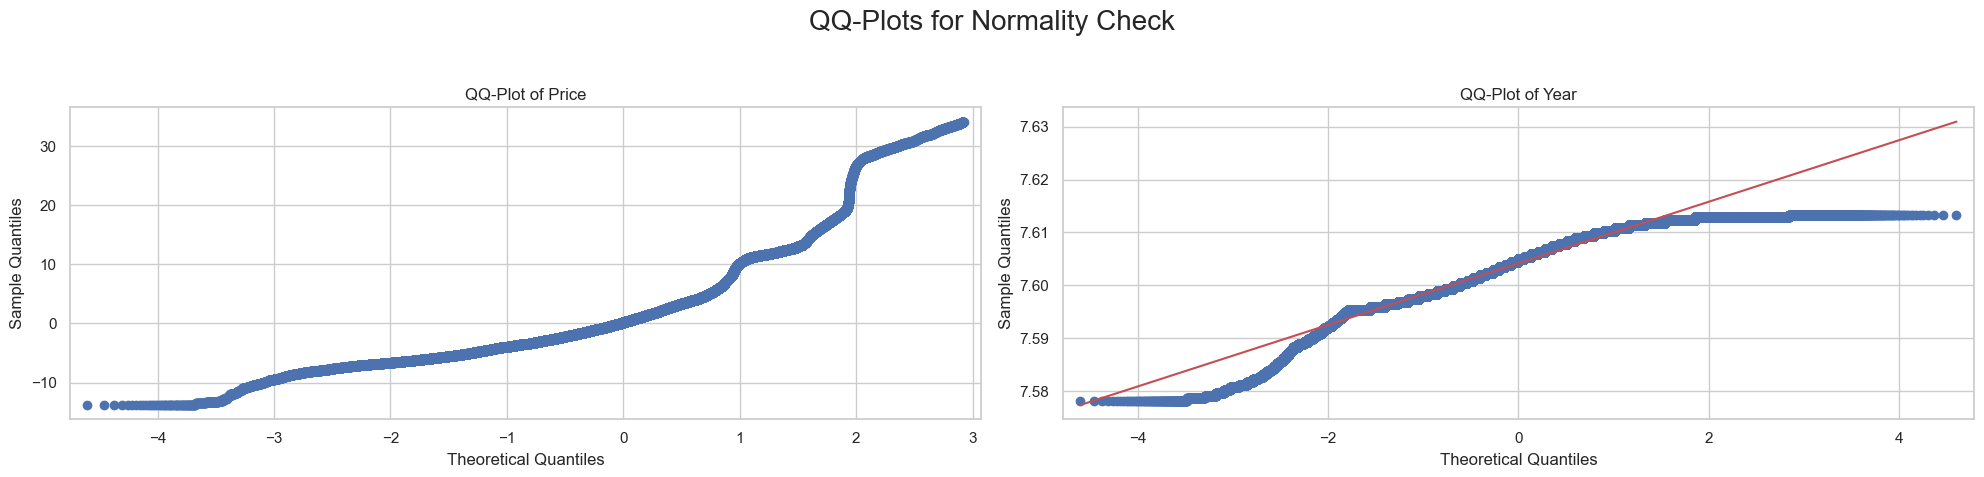

In [65]:
#Data exploration 
# Create a figure with subplots for each variable
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('QQ-Plots for Normality Check', fontsize=20)
variables = [ 'Price','Year']
for i, var in enumerate(variables):
    sm.qqplot(log_df[var], line='s', ax=axes[i])
    axes[i].set_title(f'QQ-Plot of {var}')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')
    axes[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [67]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#WARNING: DO NOT RUN THIS CELL - TAKES ABOUT A DAY TO EXECUTE, USED TO OPTIMIZE MODEL FOR LSTM. 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Methodology LSTM - Predict Future Commodities - Hyperparameter Optimization
# 4. Train-test split (optional: already trained model)
# 1. Prepare the data
# 1. Prepare the data
predict_df = log_df[['Location_ID', 'Year', 'Commodity_ID']].dropna()

# Encode Commodity_ID
commodity_encoder = LabelEncoder()
predict_df['Commodity_ID_encoded'] = commodity_encoder.fit_transform(predict_df['Commodity_ID'])

# 2. Sort by Location_ID and Year
predict_df = predict_df.sort_values(by=['Location_ID', 'Year'])

# 3. Create sequences
sequences = []
targets = []

for loc_id in predict_df['Location_ID'].unique():
    loc_data = predict_df[predict_df['Location_ID'] == loc_id]
    loc_commodities = loc_data['Commodity_ID_encoded'].values
    
    # Build sequences (window size 1, for now)
    for i in range(len(loc_commodities) - 1):
        sequences.append([loc_commodities[i]])
        targets.append(loc_commodities[i + 1])

sequences = np.array(sequences)
targets = np.array(targets)

# Reshape for LSTM (samples, time_steps, features)
sequences = sequences.reshape((sequences.shape[0], 1, 1))

# 4. Train-test split (optional: already trained model)
X_train, X_test, y_train, y_test = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=(1, 1),
                   return_sequences=False))
    
    if hp.Boolean('dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(len(np.unique(targets)), activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='lstm_commodity_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 52m 02s]
val_accuracy: 0.8943639993667603

Best val_accuracy So Far: 0.894748330116272
Total elapsed time: 1d 00h 55m 37s


C:\Users\AlexChacon\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
#NO NEED TO RUN EITHER 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
#{'units': 64, 'dropout': False, 'learning_rate': 0.001}

{'units': 64, 'dropout': False, 'learning_rate': 0.001}


In [73]:
#Methodology LSTM - Predict Future Commodities


# ❗ No need to build and fit a model — use best_model directly
# best_model is assumed to already be trained and available in memory

# 5. Predict future years using best_model
future_predictions = []
future_years = list(range(2025, 2031))
location_ids = predict_df['Location_ID'].unique()

for loc_id in location_ids:
    loc_data = predict_df[predict_df['Location_ID'] == loc_id]
    if loc_data.empty:
        continue

    last_known_commodity = loc_data.sort_values('Year')['Commodity_ID_encoded'].iloc[-1]
    input_seq = np.array([[last_known_commodity]]).reshape((1, 1, 1))

    for year in future_years:
        pred = best_model.predict(input_seq, verbose=0)
        pred_class = np.argmax(pred)
        future_predictions.append({
            'Location_ID': loc_id,
            'Year': year,
            'Predicted_Commodity_ID_encoded': pred_class
        })
        input_seq = np.array([[pred_class]]).reshape((1, 1, 1))

# 6. Create prediction DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Decode predicted commodity
future_predictions_df['Predicted_Commodity_ID'] = commodity_encoder.inverse_transform(
    future_predictions_df['Predicted_Commodity_ID_encoded']
)

# 🗺️ Map Location Names
location_mapping = final_combined_df[['Location_ID', 'Location']].dropna().drop_duplicates()
location_mapping_dict = dict(zip(location_mapping['Location_ID'], location_mapping['Location']))
future_predictions_df['Location'] = future_predictions_df['Location_ID'].map(location_mapping_dict)

# Save to CSV
csv_path = r"C:\Users\AlexChacon\Desktop\dat-490\feed_crops\future_commodity_timeseries.csv"
future_predictions_df.to_csv(csv_path, index=False)

print(future_predictions_df.head())
print(f"✅ Time series CSV saved to {csv_path}")


   Location_ID  Year  Predicted_Commodity_ID_encoded  Predicted_Commodity_ID  \
0          1.0  2025                               9                    16.0   
1          1.0  2026                               9                    16.0   
2          1.0  2027                               9                    16.0   
3          1.0  2028                               9                    16.0   
4          1.0  2029                               9                    16.0   

        Location  
0  United States  
1  United States  
2  United States  
3  United States  
4  United States  
✅ Time series CSV saved to C:\Users\AlexChacon\Desktop\dat-490\feed_crops\future_commodity_timeseries.csv


In [75]:
#Data exploration
# Drop duplicates to avoid repeats
commodity_mapping = final_combined_df[['Commodity_ID', 'Commodity_Type']].dropna().drop_duplicates()

# Sort by Commodity_ID (optional, makes it look cleaner)
commodity_mapping = commodity_mapping.sort_values('Commodity_ID')

# Print it
print(commodity_mapping)

       Commodity_ID        Commodity_Type
2299            0.0                   nan
3577            8.0  animal protein feeds
1               9.0                barley
3475           10.0       byproduct feeds
227            11.0         coarse grains
1123           12.0                  corn
32147          13.0          energy feeds
150            14.0           feed grains
4482           15.0   grain protein feeds
938            16.0                   hay
2265           17.0                  oats
4651           18.0    oilseed meal feeds
5812           19.0       processed feeds
4063           20.0               sorghum


In [77]:
#Methodology/Visualization
# 📋 Your mapping manually provided
commodity_mapping_manual = {
    0.0: np.nan,
    8.0: "animal protein feeds",
    9.0: "barley",
    10.0: "byproduct feeds",
    11.0: "coarse grains",
    12.0: "corn",
    13.0: "energy feeds",
    14.0: "feed grains",
    15.0: "grain protein feeds",
    16.0: "hay",
    17.0: "oats",
    18.0: "oilseed meal feeds",
    19.0: "processed feeds",
    20.0: "sorghum"
}

# 🛠️ Apply the mapping to add a new column
future_predictions_df['Commodity_Type'] = future_predictions_df['Predicted_Commodity_ID'].map(commodity_mapping_manual)

# ✅ Show result
print(future_predictions_df.head())

   Location_ID  Year  Predicted_Commodity_ID_encoded  Predicted_Commodity_ID  \
0          1.0  2025                               9                    16.0   
1          1.0  2026                               9                    16.0   
2          1.0  2027                               9                    16.0   
3          1.0  2028                               9                    16.0   
4          1.0  2029                               9                    16.0   

        Location Commodity_Type  
0  United States            hay  
1  United States            hay  
2  United States            hay  
3  United States            hay  
4  United States            hay  


C:\Users\AlexChacon\AppData\Local\Temp\ipykernel_24812\3140162564.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_common_per_region['Region_Name'] = most_common_per_region['Region_ID'].map(region_names)


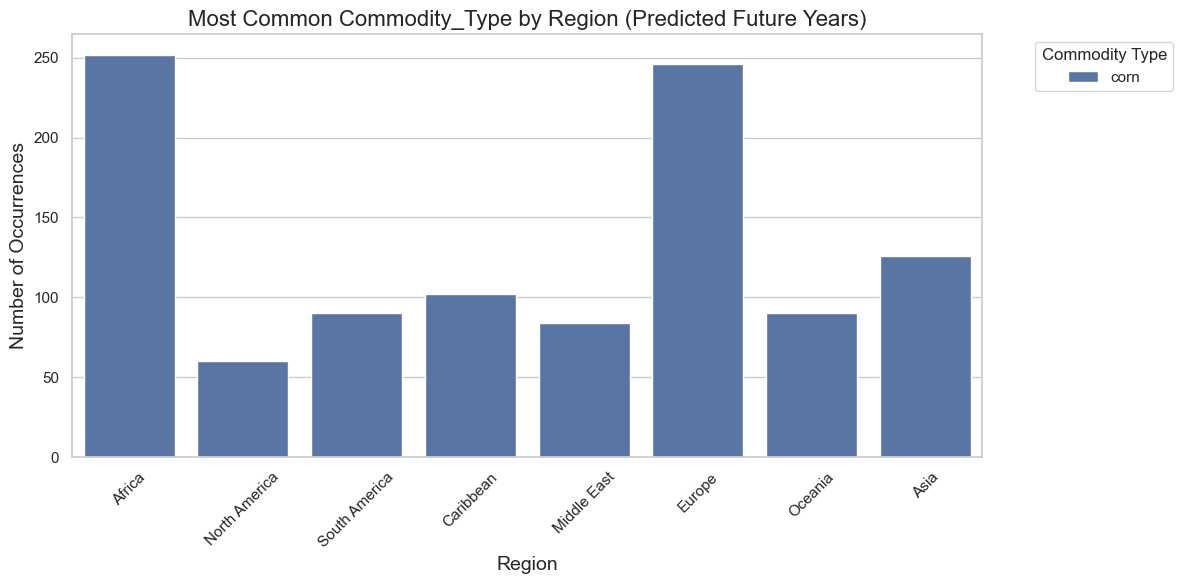

In [79]:
#Methodology/Visualization
# 1. Re-map Regions for future_predictions_df
future_predictions_df['Region_ID'] = np.nan

for region_id, country_list in region_mapping:
    future_predictions_df.loc[
        future_predictions_df['Location'].str.contains(escape_countries(country_list), case=False, na=False),
        'Region_ID'
    ] = float(region_id)

# Drop unwanted locations
locations_to_drop = [
    'World', 'World less U.S.', 'Unidentified Country', 'Western Hemisphere', 
    '    Western Hemisphere', '        Acceding-10', '    Unidentified Country'
]
future_predictions_df = future_predictions_df[~future_predictions_df['Location'].isin(locations_to_drop)]

# 2. Group and count
grouped = future_predictions_df.groupby(['Region_ID', 'Commodity_Type']).size().reset_index(name='Counts')

# 3. For each region, get the Commodity_Type with the maximum count
idx = grouped.groupby(['Region_ID'])['Counts'].transform('max') == grouped['Counts']
most_common_per_region = grouped[idx]

# 4. Map Region_ID to Region Name
region_names = {
    1: 'Africa',
    2: 'North America',
    3: 'South America',
    4: 'Caribbean',
    5: 'Middle East',
    6: 'Europe',
    7: 'Oceania',
    8: 'Asia'
}
most_common_per_region['Region_Name'] = most_common_per_region['Region_ID'].map(region_names)

# 5. Plot (now using Region_Name directly)
plt.figure(figsize=(12,6))
sns.barplot(data=most_common_per_region, x='Region_Name', y='Counts', hue='Commodity_Type', dodge=False)

plt.title('Most Common Commodity_Type by Region (Predicted Future Years)', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Commodity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

RMSE: 65887.40325307663, R-squared: 0.8613502992858455


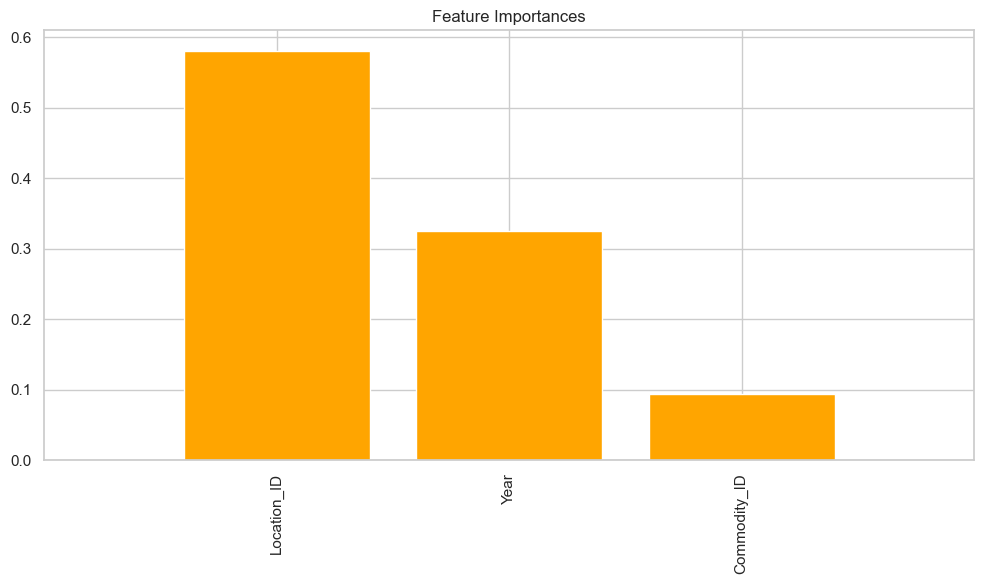

In [81]:
#Methodology - Binary Tree Forest for Feature Analysis 
#Dropped 'location' since no loger in dataset. 
#Filter for Price_Measurement_ID == 12
filtered_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 12) &
    (final_combined_df['Price'].notna())
]

# Prepare features and target
features = filtered_df[['Location_ID', 'Year', 'Commodity_ID']].dropna()
target = filtered_df.loc[features.index, 'Price']

# Ensure rows with valid target values
valid_indices = target.dropna().index
features = features.loc[valid_indices]
target = target.loc[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}, R-squared: {r2}")

# Plot random forest feature importances
importances = rf_model.feature_importances_
feature_names = features.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center", color="orange")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

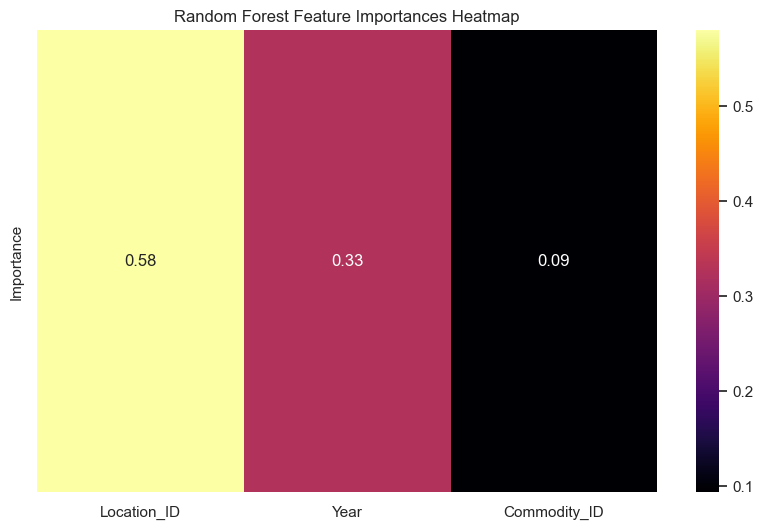

In [83]:
# Plot heatmap of random forest feature importances
plt.figure(figsize=(10, 6))
sns.heatmap(importances.reshape(1, -1), annot=True, fmt=".2f", cmap='inferno', xticklabels=feature_names, yticklabels=['Importance'])
plt.title('Random Forest Feature Importances Heatmap')
plt.show()

In [85]:
#Methodology-PCA for Price in all countries where (Price in dollars per 1000 metric tons)

Principal Component 1: 1.0000 variance explained


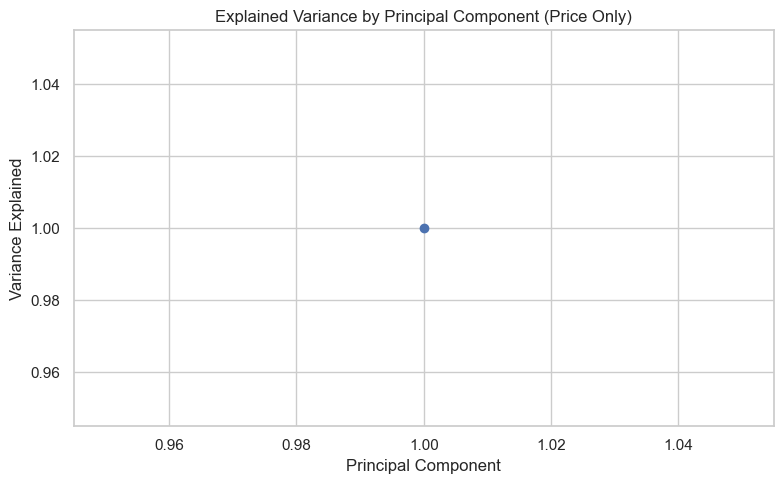

In [87]:
# Filter for Price_Measurement_ID = 12 and valid Price
pca_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 12) & 
    (final_combined_df['Price'].notna()) & 
    (final_combined_df['Price'] > 0)
]

# Select relevant columns
X = pca_df[['Commodity_ID', 'Location', 'Year']]
y = pca_df[['Price']]  # Keep as DataFrame for PCA on Price

# Define preprocessing for features
numeric_features = ['Commodity_ID', 'Year']
categorical_features = ['Location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create pipeline: preprocess X and apply PCA to y (Price)
pipeline_X = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Process features
X_transformed = pipeline_X.fit_transform(X)

# Standardize y before PCA
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Perform PCA on scaled price data (y)
pca = PCA(n_components=1)  # Just 1 component since y is 1D
y_pca = pca.fit_transform(y_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Display explained variance
for i, var in enumerate(explained_variance, 1):
    print(f"Principal Component {i}: {var:.4f} variance explained")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Principal Component (Price Only)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

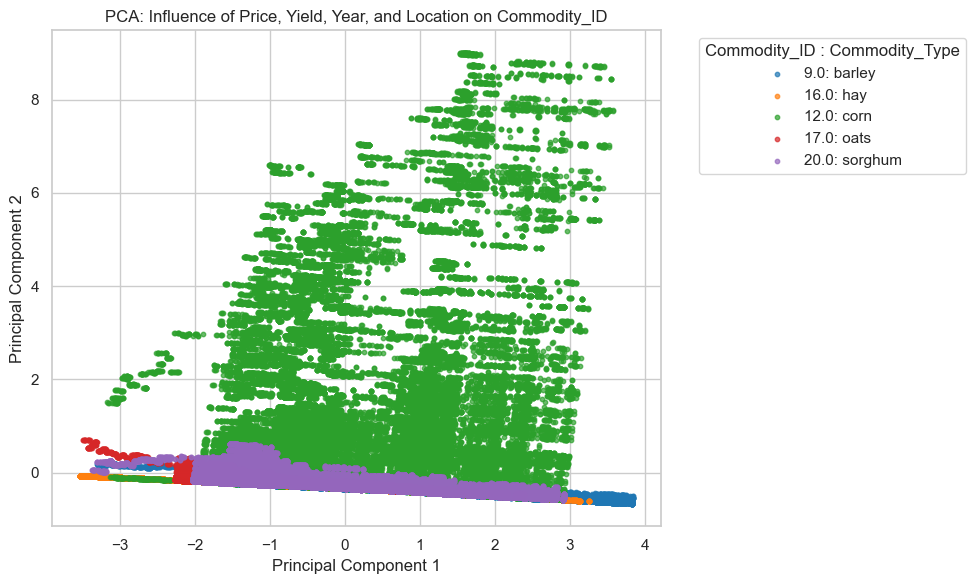

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# Step 1: Separate Yield values from Price_Measurement_ID == 7
yield_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 7) & 
    (final_combined_df['Price'].notna()) &
    (final_combined_df['Price'] > 0)
][['Commodity_ID', 'Location', 'Year', 'Price']].copy()

yield_df.rename(columns={'Price': 'Yield'}, inplace=True)

# Step 2: Get Price data (Price_Measurement_ID == 12)
price_df = final_combined_df[
    (final_combined_df['Price_Measurement_ID'] == 12) & 
    (final_combined_df['Price'].notna()) &
    (final_combined_df['Price'] > 0)
][['Commodity_ID', 'Location', 'Year', 'Price']].copy()

# Step 3: Merge yield into price_df on Commodity_ID, Location, Year
merged_df = pd.merge(price_df, yield_df, on=['Commodity_ID', 'Location', 'Year'], how='inner')

# Merge Commodity_Type info
commodity_map = final_combined_df[['Commodity_ID', 'Commodity_Type']].drop_duplicates()
merged_df = pd.merge(merged_df, commodity_map, on='Commodity_ID', how='left')

# Step 4: Set up features and target
X = merged_df[['Price', 'Yield', 'Year', 'Location']]
y = merged_df['Commodity_ID']  # Target: for coloring in PCA

# Step 5: Preprocessing pipeline
numeric_features = ['Price', 'Yield', 'Year']
categorical_features = ['Location']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Step 6: Full pipeline with PCA
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])

X_pca = pipeline.fit_transform(X)

# Step 7: Plot the PCA result
plt.figure(figsize=(10, 6))

# Create color mapping
unique_ids = merged_df['Commodity_ID'].unique()
colors = plt.cm.tab10(range(len(unique_ids)))
color_map = dict(zip(unique_ids, colors))

# Scatter plot using mapped colors
for cid in unique_ids:
    subset = merged_df[merged_df['Commodity_ID'] == cid]
    idx = subset.index
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=f"{cid}: {subset['Commodity_Type'].iloc[0]}",
        color=color_map[cid],
        s=10,
        alpha=0.7
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Influence of Price, Yield, Year, and Location on Commodity_ID')
plt.grid(True)

# Create legend
plt.legend(title='Commodity_ID : Commodity_Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [167]:
# 1. Get feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(['Price', 'Yield', 'Year'])
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Location'])
feature_names = list(num_features) + list(cat_features)

# 2. Get PCA components (loadings)
pca = pipeline.named_steps['pca']
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)

# 3. Display loadings
print(loadings)
#PC1: Pric & yeild have high influnce, PC2: Yeild has high influence 

            PC1       PC2
Price  0.704466 -0.065526
Yield  0.080540  0.996678
Year   0.705153 -0.048375


In [89]:
#Data cleaning 
# Create a mask to check if 'Location' contains 'U.S.' or 'United States'
us_mask = final_combined_df['Location'].str.contains('U.S.|United States', case=False, na=False)

# Subset the DataFrame
us_df = final_combined_df[us_mask].copy() 
us_df.head()

,Commodity_Supply_Measure,Commodity_ID,Commodity_Type,Location_ID,Location,Price_Measurement_ID,Price_Meaurement_Type,Year,Price_Measurement_Frequency,Price_Measurement_Timeperiod,Price,Year_Range,Region_ID
1,Supply and use,9.0,barley,1.0,United States,6,Bushels per acre,2005.0,Annual,Commodity Market Year,64.8,7,2.0
2,Supply and use,9.0,barley,1.0,United States,6,Bushels per acre,2006.0,Annual,Commodity Market Year,61.1,7,2.0
3,Supply and use,9.0,barley,1.0,United States,6,Bushels per acre,2007.0,Annual,Commodity Market Year,60.0,7,2.0
4,Supply and use,9.0,barley,1.0,United States,6,Bushels per acre,2008.0,Annual,Commodity Market Year,63.3,7,2.0
5,Supply and use,9.0,barley,1.0,United States,6,Bushels per acre,2009.0,Annual,Commodity Market Year,72.8,7,2.0


In [91]:
#Data cleaning 
# Define values to remove
locations_to_remove = [
    '  World less U.S.',
    '          Former Ussr, Begins 1/1989 & Ends 1/1993',
    '          Russian Federation, Begins 2/1992'
]

# Filter them out
us_df = us_df[~us_df['Location'].isin(locations_to_remove)]

In [93]:
#Data Exploration
# Filter rows where Price_Measurement_ID == 12
filtered_df = us_df[us_df['Price_Measurement_ID'] == 12]

# Group by Location (assuming column is named 'Location') and calculate the average Price
average_price_by_location = filtered_df.groupby('Location')['Price'].mean().reset_index()

# Optionally rename for clarity
average_price_by_location.columns = ['Location', 'Average_Price']

print(average_price_by_location)

                       Location  Average_Price
0                     U.S. - AR   95503.376643
1              U.S. - AR points  363342.095260
2             U.S. - Central IL  195214.494395
3             U.S. - Central US  262707.731466
4            U.S. - Chicago, IL  266900.457123
5   U.S. - Domestic, East Coast  748709.597162
6    U.S. - Golden Triangle, MT  283068.805781
7         U.S. - Gulf ports, LA  139883.964732
8          U.S. - IL points, IL  113118.422251
9        U.S. - Kansas City, MO  136713.171359
10      U.S. - Lawrenceburg, IN  132577.021599
11           U.S. - Memphis, TN  179041.400105
12               U.S. - Midwest  393044.612626
13       U.S. - Minneapolis, MN  119015.742827
14          U.S. - New York, NY  422813.094874
15             U.S. - Omaha, NE  126613.391541
16          U.S. - St Louis, MO  133543.166386
17            U.S. - Toledo, OH  128876.115820
18                United States  110023.748367


In [95]:
#Data Exploration
# Count occurrences of each Commodity_ID per Location
commodity_counts = us_df.groupby(['Location', 'Commodity_ID']).size().reset_index(name='Count')

# For each location, get the Commodity_ID with the highest count
top_commodity_per_location = commodity_counts.sort_values('Count', ascending=False).drop_duplicates('Location')

# Optional: Sort by Location for readability
top_commodity_per_location = top_commodity_per_location.sort_values('Location')

print(top_commodity_per_location)

                       Location  Commodity_ID  Count
0                     U.S. - AR          10.0    524
1              U.S. - AR points           8.0    493
2             U.S. - Central IL          12.0    643
5             U.S. - Central US           8.0    505
6            U.S. - Chicago, IL          12.0   1482
7   U.S. - Domestic, East Coast           8.0    431
8    U.S. - Golden Triangle, MT           9.0    107
9         U.S. - Gulf ports, LA          12.0    640
11         U.S. - IL points, IL          15.0    563
12       U.S. - Kansas City, MO          10.0   1656
15      U.S. - Lawrenceburg, IN          15.0    377
16           U.S. - Memphis, TN          12.0    640
18               U.S. - Midwest          12.0   1814
20       U.S. - Minneapolis, MN           9.0   1015
23          U.S. - New York, NY          12.0    839
24             U.S. - Omaha, NE          12.0    643
25          U.S. - St Louis, MO          12.0    637
26            U.S. - Toledo, OH          12.0 

In [97]:
#Data Exploration
# 1. Get average Price by Year_Range
avg_price = us_df.groupby('Year_Range')['Price'].mean().reset_index()
avg_price.columns = ['Year_Range', 'Average_Price']

# 2. Get most common Commodity_ID by Year_Range
most_common_commodity = (
    us_df.groupby(['Year_Range', 'Commodity_ID'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Year_Range', 'Count'], ascending=[True, False])
    .drop_duplicates('Year_Range')
)

# 3. Merge both results
result = pd.merge(avg_price, most_common_commodity[['Year_Range', 'Commodity_ID']], on='Year_Range')
print(result)

   Year_Range  Average_Price  Commodity_ID
0           5   1.382154e+12           0.0
1           6   6.206887e+12          12.0
2           7   5.927164e+12          12.0
3           8   7.953502e+12          12.0


In [99]:
#Data Exploration
# Count occurrences of each Price_Measurement_Type per Location
counts = (
    us_df.groupby(['Location', 'Price_Meaurement_Type'])
    .size()
    .reset_index(name='Count')
)

# Sort by Location and descending Count
sorted_counts = counts.sort_values(['Location', 'Count'], ascending=[True, False])

# Select the most common Price_Measurement_Type for each Location
most_common_pm_type = sorted_counts.drop_duplicates(subset=['Location'])

# Sort final result for readability
most_common_pm_type = most_common_pm_type.sort_values('Location').reset_index(drop=True)

# Print the result
print(most_common_pm_type)

                       Location Price_Meaurement_Type  Count
0                     U.S. - AR       Dollars per ton    524
1              U.S. - AR points       Dollars per ton    493
2             U.S. - Central IL       Dollars per ton    865
3             U.S. - Central US       Dollars per ton    505
4            U.S. - Chicago, IL       Dollars per cwt    839
5   U.S. - Domestic, East Coast       Dollars per ton    431
6    U.S. - Golden Triangle, MT    Dollars per bushel    107
7         U.S. - Gulf ports, LA    Dollars per bushel    640
8          U.S. - IL points, IL       Dollars per ton    563
9        U.S. - Kansas City, MO       Dollars per ton   1656
10      U.S. - Lawrenceburg, IN       Dollars per ton    377
11           U.S. - Memphis, TN    Dollars per bushel    640
12               U.S. - Midwest       Cents per pound   1514
13       U.S. - Minneapolis, MN    Dollars per bushel   2249
14          U.S. - New York, NY       Dollars per cwt    839
15             U.S. - Om

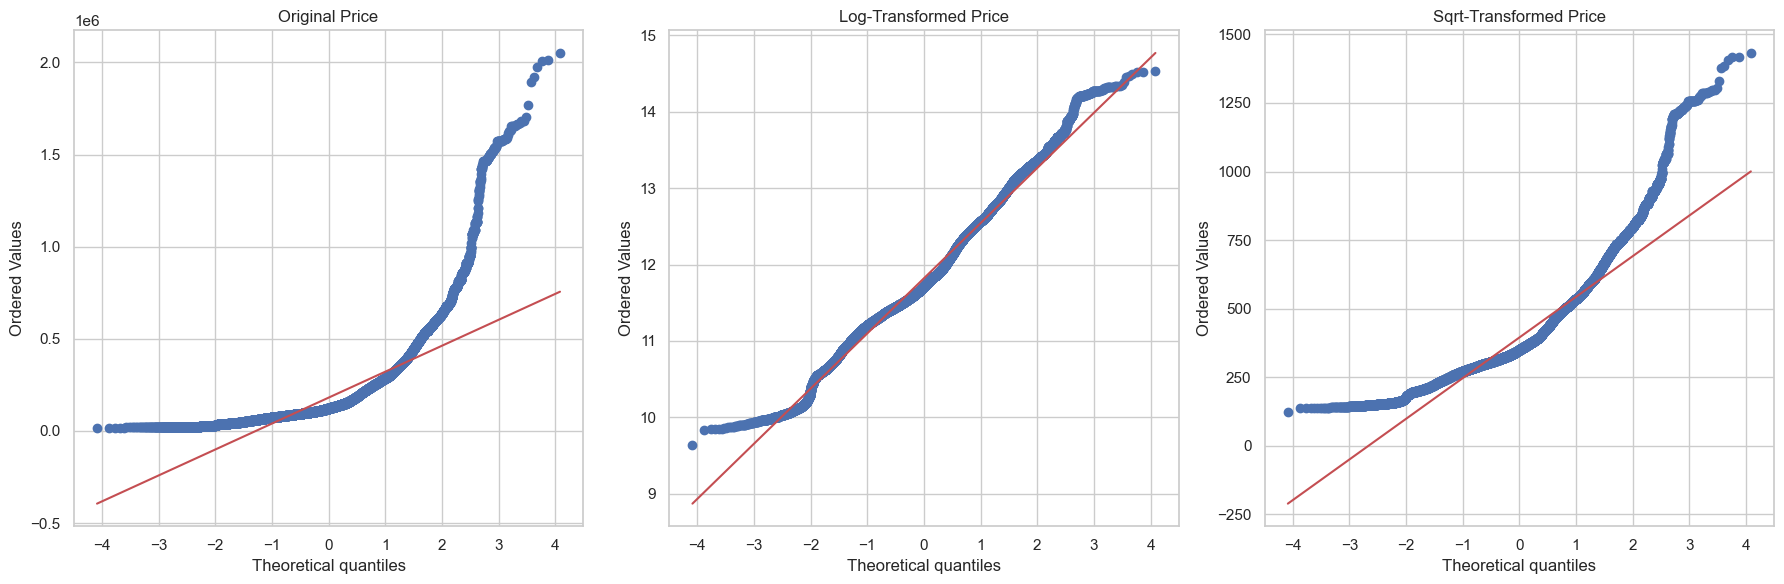

In [101]:
#Data Exploration
# Filter the data for Price_Measurement_ID == 12
price_data = us_df[us_df['Price_Measurement_ID'] == 12]['Price'].dropna()

# Apply transformations
log_price = np.log(price_data[price_data > 0])      # Ensure positive values for log
sqrt_price = np.sqrt(price_data)

# Create QQ plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original data
stats.probplot(price_data, dist="norm", plot=axes[0])
axes[0].set_title("Original Price")
axes[0].grid(True)

# Log-transformed
stats.probplot(log_price, dist="norm", plot=axes[1])
axes[1].set_title("Log-Transformed Price")
axes[1].grid(True)

# Square root-transformed
stats.probplot(sqrt_price, dist="norm", plot=axes[2])
axes[2].set_title("Sqrt-Transformed Price")
axes[2].grid(True)

plt.tight_layout()
plt.show()


Principal Component 1: 0.4074 variance explained
Principal Component 2: 0.3813 variance explained
Principal Component 3: 0.0939 variance explained
Principal Component 4: 0.0223 variance explained
Principal Component 5: 0.0176 variance explained


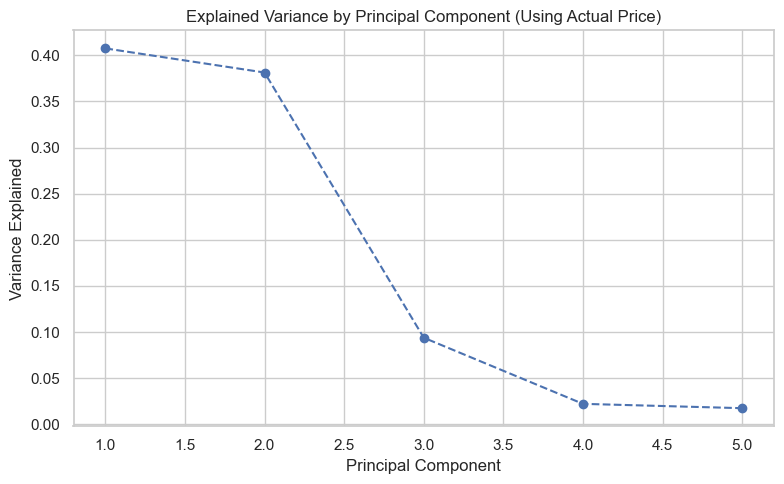

In [196]:
#Data Methodology - PCA Analysis of Price for United States
# Filter rows where Price > 0 and drop NaNs
pca_df = us_df[['Commodity_ID', 'Location', 'Year', 'Price']].dropna()
pca_df = pca_df[pca_df['Price'] > 0]

# Separate features and target
X = pca_df[['Commodity_ID', 'Location', 'Year']]
y = pca_df['Price']  # Using actual price, not log-transformed price

# Define column types
numeric_features = ['Commodity_ID', 'Year']
categorical_features = ['Location']

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create pipeline with preprocessing and PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))  # You can change this if needed
])

# Fit PCA
X_pca = pipeline.fit_transform(X)

# Access explained variance
pca_model = pipeline.named_steps['pca']
explained_variance = pca_model.explained_variance_ratio_

# Display explained variance
for i, var in enumerate(explained_variance, 1):
    print(f"Principal Component {i}: {var:.4f} variance explained")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Principal Component (Using Actual Price)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

In [200]:
#Methodology- PCA Components
# Get feature names from preprocessor
# This handles both numeric and one-hot encoded categorical features
# Get feature names from the preprocessor
cat_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_features])

# Get PCA loadings (components_)
pca_model = pipeline.named_steps['pca']
components = pca_model.components_

# Create a DataFrame of component loadings
pca_loadings = pd.DataFrame(components[:3].T,  # transpose to get features as rows
                            columns=["PC1", "PC2", "PC3"],
                            index=all_feature_names)

# Function to display top contributors
def display_top_contributors(pc_name, top_n=10):
    sorted_features = pca_loadings[pc_name].abs().sort_values(ascending=False)
    print(f"\n🔹 Top contributors to {pc_name}:")
    print(pca_loadings.loc[sorted_features.index[:top_n]])

# Show top features for PC1–PC3
for pc in ["PC1", "PC2", "PC3"]:
    display_top_contributors(pc)



🔹 Top contributors to PC1:
                                      PC1       PC2       PC3
Year                             0.711282 -0.698343  0.078328
Commodity_ID                     0.695599  0.715432  0.061333
Location_United States          -0.094144  0.011018  0.946613
Location_U.S. - Midwest          0.022485 -0.003900 -0.148725
Location_U.S. - Central IL       0.016344  0.003740 -0.065157
Location_U.S. - Kansas City, MO  0.014093 -0.001170 -0.197121
Location_U.S. - Memphis, TN      0.011688  0.006782 -0.051453
Location_U.S. - Gulf ports, LA   0.009123  0.010401 -0.050666
Location_U.S. - Chicago, IL      0.007699 -0.005989 -0.067367
Location_U.S. - New York, NY     0.006315 -0.005455 -0.035256

🔹 Top contributors to PC2:
                                           PC1       PC2       PC3
Commodity_ID                          0.695599  0.715432  0.061333
Year                                  0.711282 -0.698343  0.078328
Location_United States               -0.094144  0.011018  0.9

✅ Best parameters: {'model__n_neighbors': 5}
✅ Mean Squared Error: 4926795780.35
✅ R² Score (Price): 0.8426


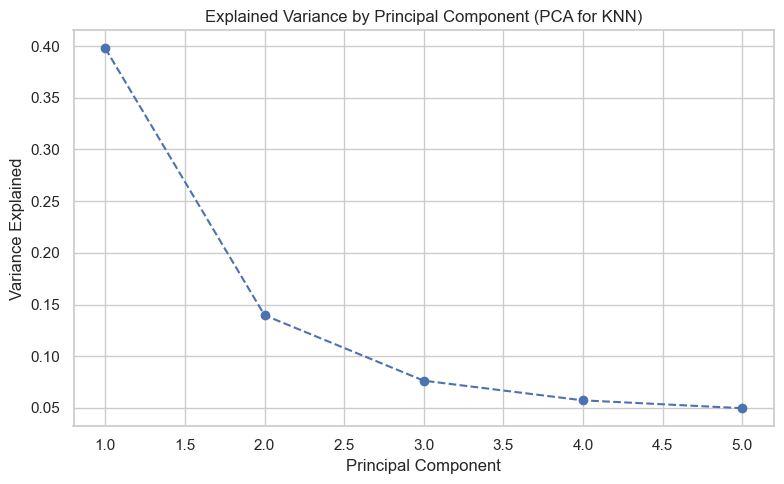

In [145]:
#Methodology - GridRegression with the PCA used as well. US Price Prediction
#DISCARD=KNN AND PCA NOT PREDICTING WELL FOR FUTURE YEAR< JUST RDIGE MODEL IS IDEAL. 
# Step 1: Filter the Data
filtered_df = us_df[['Commodity_ID', 'Location', 'Year', 'Price', 'Price_Measurement_ID']].dropna()
filtered_df = filtered_df[filtered_df['Price_Measurement_ID'] == 12]
filtered_df = filtered_df[filtered_df['Price'] > 0]

# Step 2: Define features and target
X = filtered_df[['Commodity_ID', 'Location', 'Year']]
y = filtered_df['Price']

# Step 3: Preprocessing
numeric_features = ['Year']
categorical_features = ['Commodity_ID', 'Location']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Step 4: Pipeline with PCA and KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('model', KNeighborsRegressor())
])

# Step 5: Grid search parameters
param_grid = {
    'model__n_neighbors': [3, 5, 7, 10]
}

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Step 9: Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Mean Squared Error: {mse:.2f}")
print(f"✅ R² Score (Price): {r2:.4f}")

# Optional: PCA variance plot
pca_model = best_model.named_steps['pca']
explained_variance = pca_model.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Principal Component (PCA for KNN)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

In [147]:
# Step 1: Filter and clean the data for Price_Measurement_ID = 12
filtered_df = us_df[['Commodity_ID', 'Location', 'Year', 'Price', 'Price_Measurement_ID']].dropna()
filtered_df = filtered_df[filtered_df['Price_Measurement_ID'] == 12]  # Only consider rows where Price_Measurement_ID = 12
filtered_df = filtered_df[filtered_df['Price'] > 0]  # Filter out non-positive prices

# Step 2: Define features and target
X = filtered_df[['Commodity_ID', 'Location', 'Year']]
y = filtered_df['Price']

# Step 3: Preprocessing
numeric_features = ['Year']
categorical_features = ['Commodity_ID', 'Location']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Step 4: Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', Ridge())
])

# Step 5: Grid search parameters
param_grid = {
    'poly__degree': [2, 3],
    'model__alpha': [0.1, 1.0, 10.0]
}

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Step 9: Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Mean Squared Error: {mse:.2f}")
print(f"✅ R² Score (Price): {r2:.4f}")

✅ Best parameters: {'model__alpha': 0.1, 'poly__degree': 3}
✅ Mean Squared Error: 5967459592.37
✅ R² Score (Price): 0.8094


In [149]:
#Methodology - GridSearch US Price Prediction (No PCA)
# Step 1: Filter and clean the data for Price_Measurement_ID = 12
filtered_df = us_df[['Commodity_ID', 'Location', 'Year', 'Price', 'Price_Measurement_ID']].dropna()
filtered_df = filtered_df[filtered_df['Price_Measurement_ID'] == 12]  # Only consider rows where Price_Measurement_ID = 12
filtered_df = filtered_df[filtered_df['Price'] > 0]  # Filter out non-positive prices

# Step 2: Define features and target
X = filtered_df[['Commodity_ID', 'Location', 'Year']]
y = filtered_df['Price']

# Step 3: Preprocessing
numeric_features = ['Year']
categorical_features = ['Commodity_ID', 'Location']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Step 4: Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', Ridge())
])

# Step 5: Grid search parameters
param_grid = {
    'poly__degree': [2, 3],
    'model__alpha': [0.1, 1.0, 10.0]
}

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Step 9: Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Mean Squared Error: {mse:.2f}")
print(f"✅ R² Score (Price): {r2:.4f}")

✅ Best parameters: {'model__alpha': 0.1, 'poly__degree': 3}
✅ Mean Squared Error: 5967459592.37
✅ R² Score (Price): 0.8094


In [151]:
#Methodology Exploration/Visualization
def predict_price(commodity_id, year, location, best_model):
    # Create a DataFrame for the single input
    input_df = pd.DataFrame({
        'Commodity_ID': [commodity_id],
        'Year': [year],
        'Location': [location]
    })

    # Predict price using the best model
    predicted_price = best_model.predict(input_df)

    # Print and return the predicted price
    print(f"📈 Predicted Price: ${predicted_price[0]:,.2f} per 1000 metric tons")
    return float(predicted_price[0])


predict_price(commodity_id=19, year=2000, location='U.S. - Midwest',best_model = best_model)

📈 Predicted Price: $303,306.68 per 1000 metric tons


303306.68042590586

In [153]:
#Data Exploration
# Display the top 5 most common commodity types
top_commodity_types = us_df['Commodity_Type'].value_counts().head(6)
print(top_commodity_types)

Commodity_Type
corn               15739
nan                 7440
sorghum             7288
barley              6880
oats                5183
byproduct feeds     3842
Name: count, dtype: int64


In [155]:
#Data Prediction - Analysis 
# Define the years range
years = [float(year) for year in range(2026, 2050 + 1)]


# Get unique commodity IDs from the original DataFrame
commodity_ids = us_df['Commodity_ID'].unique()

# Initialize list to collect rows
predictions = []

# Loop over each combination of commodity ID and year
for commodity_id in commodity_ids:
    for year in years:
        price = predict_price(commodity_id, year, 'United States', best_model = best_model)
        predictions.append({
            "price": price,
            "year": year,
            "Commodity_ID": commodity_id
        })

# Create the predicted_us DataFrame
predicted_us = pd.DataFrame(predictions)

📈 Predicted Price: $303,853.06 per 1000 metric tons
📈 Predicted Price: $313,439.08 per 1000 metric tons
📈 Predicted Price: $323,286.36 per 1000 metric tons
📈 Predicted Price: $333,398.77 per 1000 metric tons
📈 Predicted Price: $343,780.13 per 1000 metric tons
📈 Predicted Price: $354,434.30 per 1000 metric tons
📈 Predicted Price: $365,365.13 per 1000 metric tons
📈 Predicted Price: $376,576.45 per 1000 metric tons
📈 Predicted Price: $388,072.12 per 1000 metric tons
📈 Predicted Price: $399,855.98 per 1000 metric tons
📈 Predicted Price: $411,931.88 per 1000 metric tons
📈 Predicted Price: $424,303.66 per 1000 metric tons
📈 Predicted Price: $436,975.17 per 1000 metric tons
📈 Predicted Price: $449,950.25 per 1000 metric tons
📈 Predicted Price: $463,232.75 per 1000 metric tons
📈 Predicted Price: $476,826.52 per 1000 metric tons
📈 Predicted Price: $490,735.41 per 1000 metric tons
📈 Predicted Price: $504,963.24 per 1000 metric tons
📈 Predicted Price: $519,513.89 per 1000 metric tons
📈 Predicted 

C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.

📈 Predicted Price: $312,499.26 per 1000 metric tons
📈 Predicted Price: $321,903.58 per 1000 metric tons
📈 Predicted Price: $331,553.28 per 1000 metric tons
📈 Predicted Price: $341,452.20 per 1000 metric tons
📈 Predicted Price: $351,604.20 per 1000 metric tons
📈 Predicted Price: $362,013.12 per 1000 metric tons
📈 Predicted Price: $372,682.80 per 1000 metric tons
📈 Predicted Price: $383,617.09 per 1000 metric tons
📈 Predicted Price: $394,819.84 per 1000 metric tons
📈 Predicted Price: $406,294.89 per 1000 metric tons
📈 Predicted Price: $418,046.09 per 1000 metric tons
📈 Predicted Price: $430,077.28 per 1000 metric tons
📈 Predicted Price: $442,392.32 per 1000 metric tons
📈 Predicted Price: $454,995.03 per 1000 metric tons
📈 Predicted Price: $467,889.28 per 1000 metric tons
📈 Predicted Price: $221,353.66 per 1000 metric tons
📈 Predicted Price: $227,800.68 per 1000 metric tons
📈 Predicted Price: $234,450.09 per 1000 metric tons
📈 Predicted Price: $241,305.74 per 1000 metric tons
📈 Predicted 

C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.

📈 Predicted Price: $193,955.62 per 1000 metric tons
📈 Predicted Price: $205,630.44 per 1000 metric tons
📈 Predicted Price: $217,680.36 per 1000 metric tons
📈 Predicted Price: $230,109.24 per 1000 metric tons
📈 Predicted Price: $242,920.90 per 1000 metric tons
📈 Predicted Price: $256,119.22 per 1000 metric tons
📈 Predicted Price: $269,708.01 per 1000 metric tons
📈 Predicted Price: $283,691.15 per 1000 metric tons
📈 Predicted Price: $298,072.46 per 1000 metric tons
📈 Predicted Price: $312,855.79 per 1000 metric tons
📈 Predicted Price: $328,045.00 per 1000 metric tons
📈 Predicted Price: $343,643.92 per 1000 metric tons
📈 Predicted Price: $359,656.41 per 1000 metric tons
📈 Predicted Price: $376,086.30 per 1000 metric tons
📈 Predicted Price: $392,937.45 per 1000 metric tons
📈 Predicted Price: $410,213.70 per 1000 metric tons
📈 Predicted Price: $427,918.90 per 1000 metric tons
📈 Predicted Price: $420,592.16 per 1000 metric tons
📈 Predicted Price: $436,464.46 per 1000 metric tons
📈 Predicted 

C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\AlexChacon\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.

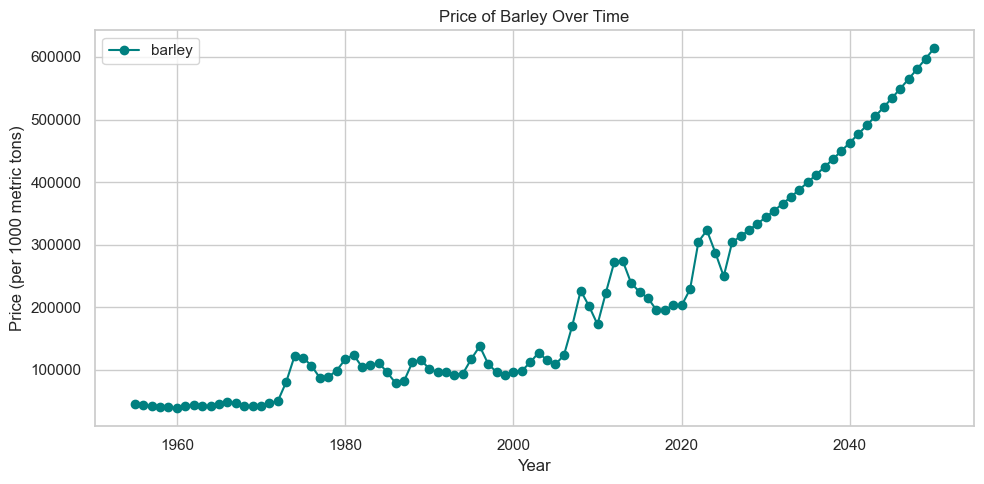

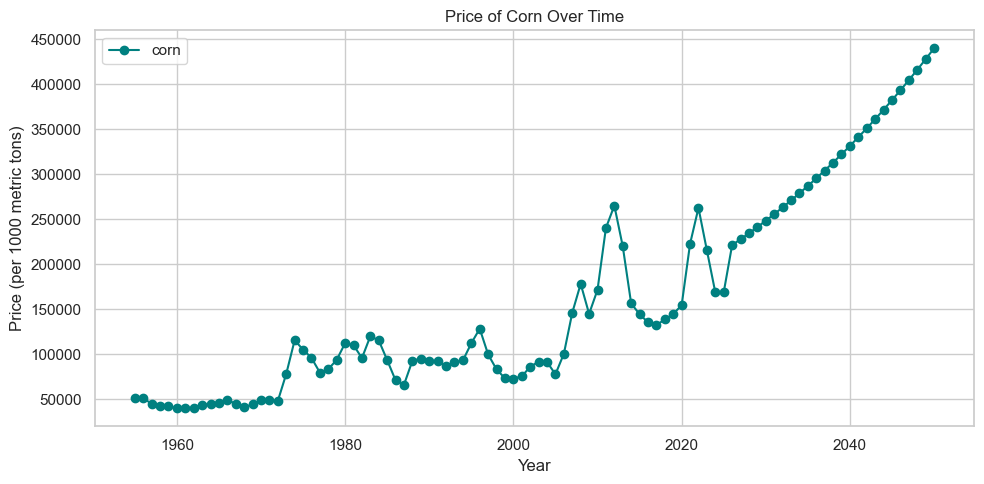

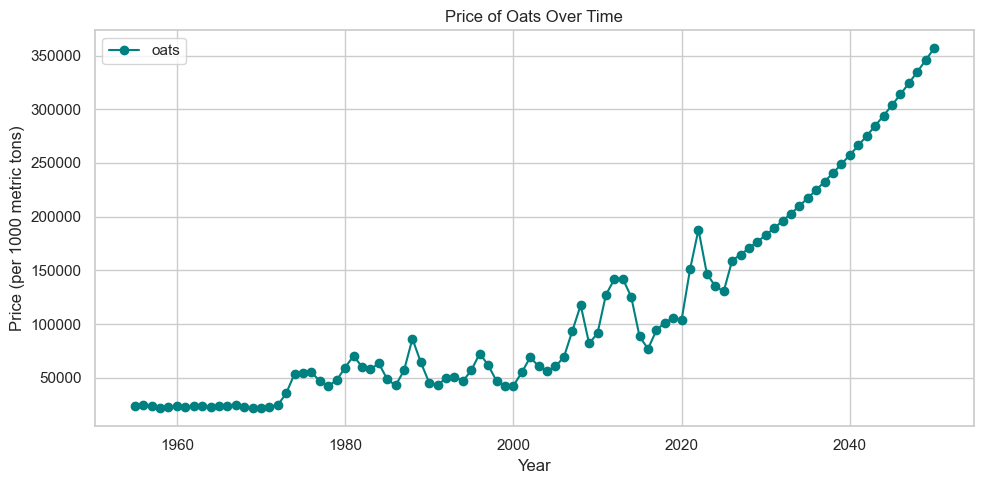

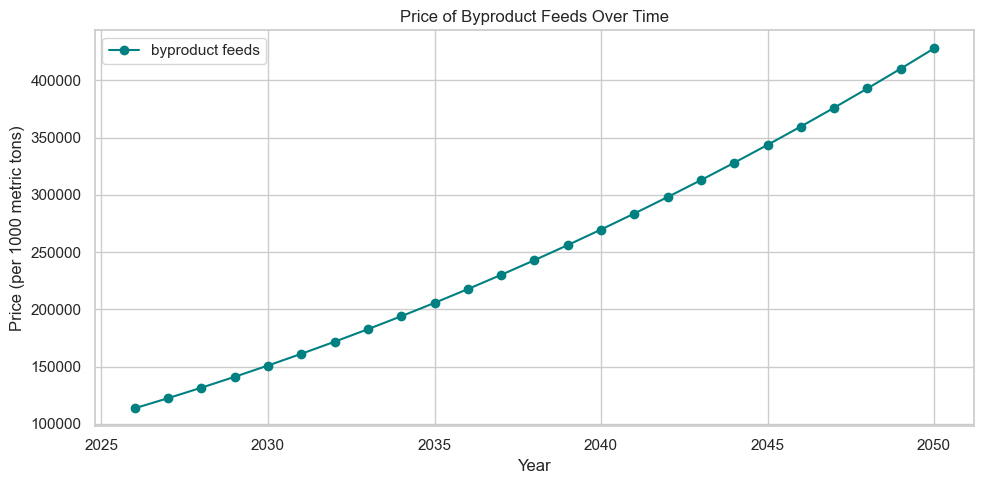

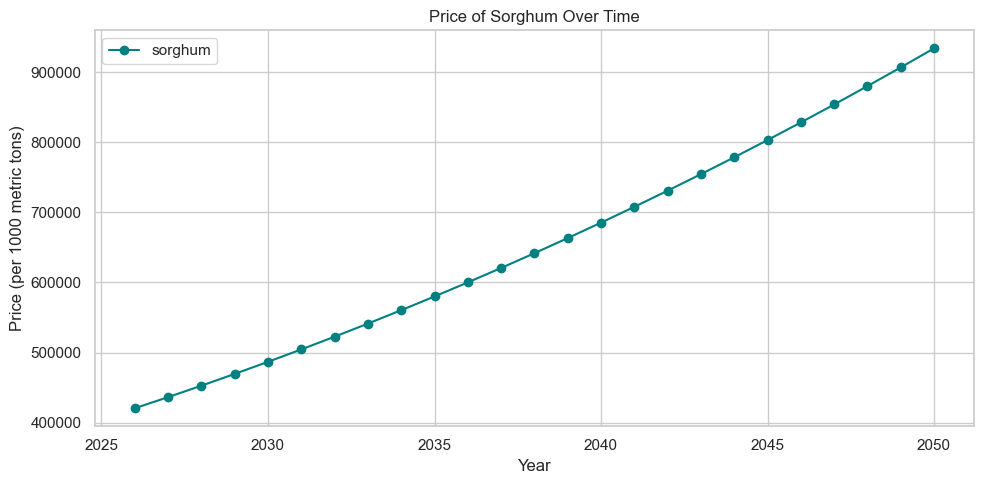

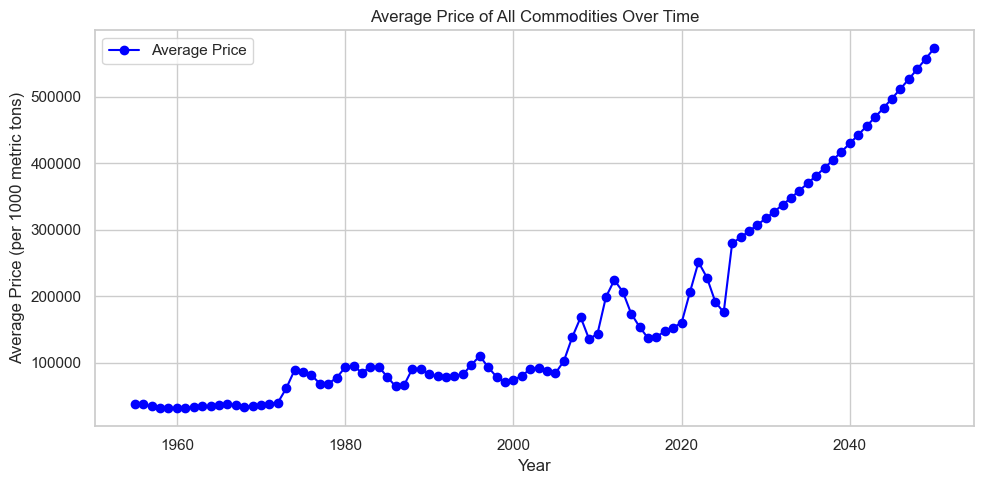

In [156]:
#Data Analysis - Visualization 
# Filter for United States, correct year range, and Price_Measurement_ID = 12
filtered = us_df[
    (us_df['Location'] == 'United States') &
    (us_df['Year'].between(1955, 2025)) &
    (us_df['Price_Measurement_ID'] == 12)
]

# Group by year and Commodity_ID, then take the mean of Price
grouped = filtered.groupby(['Year', 'Commodity_ID'])['Price'].mean().reset_index()

# Rename columns to match target structure
previous_us = grouped.rename(columns={'Price': 'price', 'Year': 'year'})
combined_us = pd.concat([previous_us, predicted_us], ignore_index=True)

# Define the commodity mapping
commodity_map = {
    12.0: "corn",         # Note: you mentioned 12.0 for both corn and sorghum — assuming typo.
    9.0: "barley",
    13.0: "sorghum",      # Assigning 13.0 to sorghum to avoid overlap with corn.
    17.0: "oats",
    10.0: "byproduct feeds"
}

# Filter combined_us
filtered_us = combined_us[combined_us['Commodity_ID'].isin(commodity_map.keys())].copy()

# Map names
filtered_us['Feed'] = filtered_us['Commodity_ID'].map(commodity_map)

# Sort for plotting
filtered_us = filtered_us.sort_values(by='year')

# Plot each feed on its own graph
for feed_name in filtered_us['Feed'].unique():
    subset = filtered_us[filtered_us['Feed'] == feed_name]

    plt.figure(figsize=(10, 5))
    plt.plot(subset['year'], subset['price'], marker='o', label=feed_name, color='teal')
    plt.title(f'Price of {feed_name.title()} Over Time')
    plt.xlabel('Year')
    plt.ylabel('Price (per 1000 metric tons)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

filtered_us = combined_us[['Commodity_ID', 'year', 'price']].copy()

# Calculate the average price for each year across all commodities
average_price_per_year = filtered_us.groupby('year')['price'].mean().reset_index()

# Plot the average price over time
plt.figure(figsize=(10, 5))
plt.plot(average_price_per_year['year'], average_price_per_year['price'], marker='o', label='Average Price', color='blue')
plt.title('Average Price of All Commodities Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price (per 1000 metric tons)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()